### Preparation of datasets


Here, I would like to prepare an Anndata object containing data for differentiation of adult blood cell types

1. In house proteomics
2. Mann group proteomics (mannlab2017_doi10.1038ni.3693)
3. HPA RNAseq data (normalised) dataset 1
4. HPA RNAseq data (normalised) dataset 2
5. Anndata from scanpy

In [2]:
import re
import numpy as np
import pandas as pd
import anndata as ad
import mudata as md
import muon as mu
import mofax as mfx
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import sklearn as sk

from collections import defaultdict
from tqdm import tqdm
from pathlib import Path

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0

In [4]:
def plot_dist(data, dist_name):
    random_genes = np.random.choice(data.columns, size=20, replace=False)
    plt.figure(figsize=(8, 5))
    sns.histplot(data.loc[:, random_genes], bins=20, kde=True, legend=False)
    plt.title(f"Distribution of 100 random genes in {dist_name}")
    plt.xlabel("Raw protein abundance")
    plt.ylabel("Frequency")
    plt.show()

In [5]:
p = Path().cwd().parent
path_data_intermediate = p / "data" / "intermediate"
path_data_intermediate

PosixPath('/home/t.afanasyeva/multimodal_blood_atlas/data/intermediate')

## 1. In house proteomics

In [5]:
# blood_atlas = pd.read_csv(
#     "/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/multimodal/proteomics/own_blood_atlas/BloodAtlas_proteinGroups-copynumber.tsv",
#     sep="\t",
# )
# blood_atlas.index = blood_atlas["Gene names"]

# copy_number_cols = [col for col in blood_atlas.columns if "Copy_number" in col]
# blood_atlas = blood_atlas[copy_number_cols]
# copy_number_cols = [col.replace("Copy_number ", "") for col in copy_number_cols]
# copy_number_cols = [col.replace(".raw", "") for col in copy_number_cols]
# copy_number_cols = [col.replace("E..Natasja.", "") for col in copy_number_cols]
# blood_atlas.columns = copy_number_cols
# blood_atlas.to_csv(path_data_intermediate / "blood_atlas_original_names.csv")

In [9]:
blood_atlas = pd.read_csv(
    path_data_intermediate / "blood_atlas_original_names.csv", index_col=0
)
blood_atlas

,Baso_0287,Baso_0681,Baso_0801,Baso_1795,Baso_5549,CD4.Tcm_0287,CD4.Tcm_0681,CD4.Tcm_1203,CD4.Tcm_1795,CD4.Tcm_1796,...,UM.IgM_1203,UM.IgM_1795,UM.IgM_1796,UM.IgM_5549,UM.IgMD._0287,UM.IgMD._0681,UM.IgMD._1203,UM.IgMD._1795,UM.IgMD._1796,UM.IgMD._5549
Genes,,,,,,,,,,,,,,,,,,,,,
NUDT4B,9945,0,7659,13104,8394,3037,4982,3003,4637,0.0,...,3678,3867,3107,4448,2983,2066,3370,4107,3180,3963
NUDT10;NUDT3;NUDT4;NUDT4B,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
NUDT10;NUDT4;NUDT4B,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
NUDT4;NUDT4B,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
IGKV3-7;IGKV3D-7,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORC2,1456,1812,1593,946,1386,1920,2162,1921,2138,2038.0,...,2039,2121,2502,2092,2217,2405,2321,2290,2326,2273
IVNS1ABP,1202,2931,1859,1255,1212,2055,3613,3548,3394,3470.0,...,1903,1686,2805,2028,1963,1812,1550,1910,1936,1769
CAMTA1,0,0,0,0,0,0,0,0,0,0.0,...,27,0,0,0,0,0,0,0,0,0


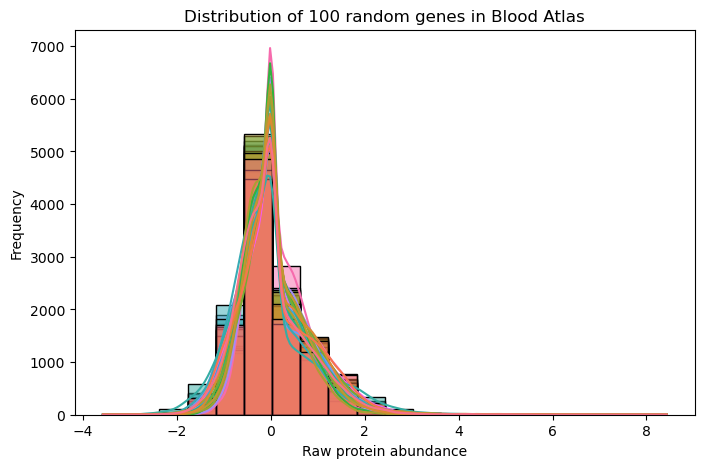

In [ ]:
blood_atlas.index = blood_atlas.index.astype(str)
blood_atlas_scaled = normalize(blood_atlas)
plot_dist(blood_atlas_scaled, "Blood Atlas")

In [14]:
blood_atlas_scaled.to_csv(
    path_data_intermediate / "191025_blood_atlas_normalized.csv"
)

## 2. Mann2017 proteomics

In [ ]:
# mann2017_df = pd.read_excel(
#     "/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/multimodal/proteomics/mannlab2017_doi10.1038ni.3693/41590_2017_BFni3693_MOESM13_ESM.xlsx"
# )
# mann2017_df = mann2017_df.drop_duplicates(subset="Gene names")
# mann2017_df = mann2017_df.drop(
#     columns=[col for col in mann2017_df.columns if "activated" in col]
# )
# mann2017_df.columns = [col.replace("CopyNumber_", "") for col in mann2017_df.columns]
# mann2017_df.columns = [col.replace("_steady-state", "") for col in mann2017_df.columns]
# mann2017_df.drop(columns=["Majority protein IDs"], inplace=True)
# mann2017_df = mann2017_df.set_index("Gene names")
# mann2017_df.index.name = "Genes"
# mann2017_df.to_csv(path_data_intermediate / "mann2017_cleaned_original_names.csv")

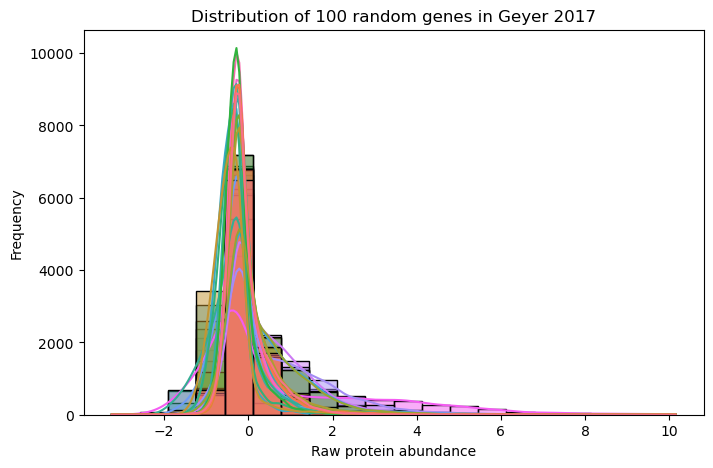

In [ ]:
mann2017_df = pd.read_csv(
    path_data_intermediate / "mann2017_cleaned_original_names.csv", index_col=0
)
mann2017_df.index = mann2017_df.index.astype(str)
mann2017_df_scaled = normalize(mann2017_df)
plot_dist(mann2017_df_scaled, "Geyer 2017")

In [ ]:
mann2017_df_scaled.to_csv(path_data_intermediate / "191025_mann2017_normalized.csv")

## 3.  HPA RNA seq 

In [ ]:
path_nra = Path(
    "/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/multimodal/transcriptomics"
)

In [25]:
path_nra / "rna_immune_cell_sample.tsv.zip"

PosixPath('/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/multimodal/transcriptomics/rna_immune_cell_sample.tsv.zip')

In [72]:
monaco = pd.read_csv(path_nra / "rna_immune_cell_sample.tsv.zip", index_col=0, sep="\t")
monaco.head(5)

,Donor,Immune cell,ENSG ID,Gene name,TPM,pTPM,nTPM
Sample ID,,,,,,,
940,a,eosinophil,ENSG00000000003,TSPAN6,0.0397,0.0493,0.0542
940,a,eosinophil,ENSG00000000005,TNMD,0.0000,0.0000,0.0000
940,a,eosinophil,ENSG00000000419,DPM1,16.8694,20.9751,23.0553
940,a,eosinophil,ENSG00000000457,SCYL3,7.2059,8.9597,9.8483
940,a,eosinophil,ENSG00000000460,C1orf112,0.0000,0.0000,0.0000


In [73]:
monaco.reset_index(inplace=True)
monaco.drop(columns=["Sample ID", "Donor", "ENSG ID", "pTPM", "nTPM"], inplace=True)
monaco.rename(columns={"Gene name": "Genes"}, inplace=True)
monaco = monaco.pivot_table(index="Genes", columns="Immune cell", values="TPM")
monaco.index.name = "Gene"

monaco.head(5)

Immune cell,MAIT T-cell,NK-cell,T-reg,basophil,classical monocyte,eosinophil,gdT-cell,intermediate monocyte,memory B-cell,memory CD4 T-cell,memory CD8 T-cell,myeloid DC,naive B-cell,naive CD4 T-cell,naive CD8 T-cell,neutrophil,non-classical monocyte,plasmacytoid DC,total PBMC
Gene,,,,,,,,,,,,,,,,,,,
A1BG,0.088450,0.015100,0.071833,0.000000,0.020867,0.0000,0.012083,0.000000,0.013233,0.073383,0.08192,0.08360,0.061933,0.007167,0.066467,0.000000,0.00000,0.201267,0.047067
A1CF,0.010483,0.021683,0.004583,0.162550,0.009167,0.0201,0.012017,0.004783,0.003617,0.007550,0.00798,0.00318,0.015800,0.010017,0.010750,0.020183,0.00400,0.010883,0.001317
A2M,0.890967,0.010717,0.002850,0.021125,0.130233,0.0000,1.688967,0.070533,0.052850,0.182283,0.45410,0.12018,0.004317,0.032033,0.245483,0.000000,0.00730,0.468483,0.054650
A2ML1,0.100933,0.200967,0.064183,0.228525,0.097500,0.0631,0.142200,0.140100,0.105450,0.065800,0.05908,0.05484,0.116967,0.066183,0.091017,0.166517,0.28978,0.158267,0.023500
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.004183,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.016750,0.000000,0.204000,0.00000,0.000000,0.000000


In [74]:
monaco = monaco.drop(columns=[col for col in df1.columns if "activated" in col])
monaco.columns

Index(['MAIT T-cell', 'NK-cell', 'T-reg', 'basophil', 'classical monocyte',
       'eosinophil', 'gdT-cell', 'intermediate monocyte', 'memory B-cell',
       'memory CD4 T-cell', 'memory CD8 T-cell', 'myeloid DC', 'naive B-cell',
       'naive CD4 T-cell', 'naive CD8 T-cell', 'neutrophil',
       'non-classical monocyte', 'plasmacytoid DC', 'total PBMC'],
      dtype='object', name='Immune cell')

In [82]:
monaco.to_csv(path_data_intermediate / "201025_monaco.csv")

In [54]:
df2 = pd.read_csv(path_nra / "rna_immune_cell_samples.tsv.zip", index_col=0, sep="\t")
df2.head(2)

,HPA sample ID,Sex
Cell type,,
basophil,976,Female
basophil,995,Female
basophil,1022,Male
basophil,1040,Female
classical monocyte,941,Male
classical monocyte,958,Male
classical monocyte,977,Female
classical monocyte,996,Female
classical monocyte,1018,Male


In [34]:
df3 = pd.read_csv(
    path_nra / "rna_immune_cell_schmiedel_immune_cells.tsv.zip", index_col=0, sep="\t"
)
df3.head(10)

,Lineage
Immune cell,
classical monocyte,monocytes
Memory CD4 T-cell TFH,T-cells
Memory CD4 T-cell Th1,T-cells
Memory CD4 T-cell Th1/Th17,T-cells
Memory CD4 T-cell Th17,T-cells
Memory CD4 T-cell Th2,T-cells
Memory T-reg,T-cells
naive B-cell,B-cells
naive CD4 T-cell,T-cells


In [ ]:
schmiedel = pd.read_csv(path_nra / "rna_immune_cell_schmiedel.tsv.zip", sep="\t")
schmiedel.rename(columns={"Gene name": "Genes"}, inplace=True)
schmiedel.drop(columns=["Gene"], inplace=True)
schmiedel = schmiedel.pivot_table(index="Genes", columns="Immune cell", values="TPM")
schmiedel = schmiedel.drop(
    columns=[col for col in schmiedel.columns if "activated" in col]
)
schmiedel.columns.to_list()

['Memory CD4 T-cell TFH',
 'Memory CD4 T-cell Th1',
 'Memory CD4 T-cell Th1/Th17',
 'Memory CD4 T-cell Th17',
 'Memory CD4 T-cell Th2',
 'Memory T-reg',
 'NK-cell',
 'Naive T-reg',
 'classical monocyte',
 'naive B-cell',
 'naive CD4 T-cell',
 'naive CD8 T-cell',
 'non-classical monocyte']

In [80]:
schmiedel.to_csv(path_data_intermediate / "201025_schmiedel.csv")

## 4. Mapping names

Samples to likely drop based on difference between own blood atlas and Mann2017 dataset:

gd.T, MAIT, Pooled, "mDC1", "mDC2", "NK.CD2.", "Th1", "Th2", "Th17", "Tfh"

"mDC1", "mDC2" --> to check with PCA

"Naive.IgD": "B_Naive",
"Naive.IgMD.": "B_Naive",
"B.naive": "B_Naive",
"PreMem.B": "B_Memory",
"UM.IgM": "B_Memory",
"UM.IgMD.": "B_Memory",
"SM.IgG.": "B_Memory",
"SM.IgA.": "B_Memory",
"SM.IgGD.": "B_Memory",
"B.memory": "B_Memory",
"Transitional.B": "B_Transitional",
"B.plasma": "B_Plasma", --> to check with PCA

In [33]:
subset_name_map = {
    # =====================
    # Granulocytes
    # =====================
    "Baso": "Basophil",
    "Basophil": "Basophil",
    "basophil": "Basophil",
    "Eos": "Eosinophil",
    "Eosinophil": "Eosinophil",
    "eosinophil": "Eosinophil",
    "Neutro": "Neutrophil",
    "Neutrophil": "Neutrophil",
    "neutrophil": "Neutrophil",
    # =====================
    # Monocytes
    # =====================
    "Mono.classic": "Monocyte_Classical",
    "MO.classical": "Monocyte_Classical",
    "classical monocyte": "Monocyte_Classical",
    "Mono.inter": "Monocyte_Intermediate",
    "MO.intermediate": "Monocyte_Intermediate",
    "intermediate monocyte": "Monocyte_Intermediate",
    "Mono.alt": "Monocyte_Nonclassical",
    "MO.nonclassical": "Monocyte_Nonclassical",
    "non-classical monocyte": "Monocyte_Nonclassical",
    # =====================
    # Dendritic cells
    # =====================
    "mDC": "Myeloid_DC",
    "myeloid DC": "Myeloid_DC",
    "pDC": "Plasmacytoid_DC",
    "plasmacytoid DC": "Plasmacytoid_DC",
    # =====================
    # NK cells
    # =====================
    "NK.CD56.": "NK_Bright",
    "NK.CD56..": "NK_Bright",
    "NK.bright": "NK_Bright",
    "NK.CD16.": "NK_Dim",
    "NK.dim": "NK_Dim",
    "NK-cell": "NK_Dim",  # default to dim if unspecified
    "NK cell": "NK_Dim",
    # =====================
    # CD4 T cells
    # =====================
    "CD4.Tn": "CD4_Naive",
    "T4.naive": "CD4_Naive",
    "naive CD4 T-cell": "CD4_Naive",
    "Naive CD4 T-cell activated": "CD4_Naive_Activated",
    "CD4.Tcm": "CD4_CentralMemory",
    "T4.CM": "CD4_CentralMemory",
    "CD4.Tem": "CD4_EffectorMemory",
    "T4.EM": "CD4_EffectorMemory",
    "CD4.Temra": "CD4_TEMRA",
    "T4.EMRA": "CD4_TEMRA",
    "memory CD4 T-cell": "CD4_EffectorMemory",
    # CD4 Memory subsets
    "Th1": "CD4_MemoryTh1",
    "Th2": "CD4_MemoryTh2",
    "Th17": "CD4_MemoryTh17",
    "Tfh": "CD4_MemoryTfh",
    "Memory CD4 T-cell Th1": "CD4_MemoryTh1",
    "Memory CD4 T-cell Th2": "CD4_MemoryTh2",
    "Memory CD4 T-cell Th17": "CD4_MemoryTh17",
    "Memory CD4 T-cell Th1/Th17": "CD4_MemoryTh1/Th17",
    "Memory CD4 T-cell TFH": "CD4_MemoryTfh",
    # =====================
    # CD8 T cells
    # =====================
    "CD8.Tn": "CD8_Naive",
    "T8.naive": "CD8_Naive",
    "naive CD8 T-cell": "CD8_Naive",
    "Naive CD8 T-cell activated": "CD8_Naive_Activated",
    "CD8.Tcm": "CD8_CentralMemory",
    "T8.CM": "CD8_CentralMemory",
    "CD8.Tem": "CD8_EffectorMemory",
    "T8.EM": "CD8_EffectorMemory",
    "CD8.Temra": "CD8_TEMRA",
    "T8.EMRA": "CD8_TEMRA",
    "memory CD8 T-cell": "CD8_EffectorMemory",
    # =====================
    # Regulatory T cells
    # =====================
    "Treg": "CD4_Treg",
    "T-reg": "CD4_Treg",
    "mTregs": "CD4_Treg",
    "nTregs": "CD4_Treg",
    "Memory T-reg": "CD4_Treg_Memory",
    "Naive T-reg": "CD4_Treg_Naive",
    # =====================
    # Extra T cells
    # =====================
    "gd.T": "T_GammaDelta",
    "gdT-cell": "T_GammaDelta",
    "MAIT": "T_MAIT",
    "MAIT T-cell": "T_MAIT",
    # =====================
    # B cells
    # =====================
    "Naive.IgD": "B_Naive",
    "Naive.IgMD.": "B_Naive",
    "B.naive": "B_Naive",
    "naive B-cell": "B_Naive",
    "PreMem.B": "B_Memory",
    "B.memory": "B_Memory",
    "memory B-cell": "B_Memory",
    "Transitional.B": "B_Transitional",
    "B.plasma": "B_Plasma",
}


def map_column_name(df, names=subset_name_map):
    old_columns = [col.split("_")[0] for col in df.columns]
    mapped = [names.get(x, x) for x in old_columns]
    counts = {}
    new_columns_counted = []
    for name in mapped:
        counts[name] = counts.get(name, 0) + 1
        new_columns_counted.append(f"{name}_{counts[name]:02d}")

    return new_columns_counted

<!-- Original subset at 250116:
    # Granulocytes
    "Baso": "Basophil",
    "Basophil": "Basophil",
    "Eos": "Eosinophil",
    "Eosinophil": "Eosinophil",
    "Neutro": "Neutrophil",
    "Neutrophil": "Neutrophil",
    # Monocytes
    "Mono.classic": "Monocyte_Classical",
    "MO.classical": "Monocyte_Classical",
    "Mono.inter": "Monocyte_Intermediate",
    "MO.intermediate": "Monocyte_Intermediate",
    "Mono.alt": "Monocyte_Nonclassical",
    "MO.nonclassical": "Monocyte_Nonclassical",
    # Dendritic cells
    "mDC": "Myeloid_DC",
    "mDC1": "Myeloid_DC",
    "mDC2": "Myeloid_DC",
    "pDC": "Plasmacytoid_DC",
    # NK cells
    "NK.CD56.": "NK_Bright",
    "NK.bright": "NK_Bright",
    "NK.CD16.": "NK_Dim",
    "NK.dim": "NK_Dim",
    "NK.CD2.": "NK_Unknown",
    # CD4 T cells
    "CD4.Tn": "CD4_Naive",
    "T4.naive": "CD4_Naive",
    "CD4.Tcm": "CD4_CentralMemory",
    "T4.CM": "CD4_CentralMemory",
    "CD4.Tem": "CD4_EffectorMemory",
    "T4.EM": "CD4_EffectorMemory",
    "CD4.Temra": "CD4_TEMRA",
    "T4.EMRA": "CD4_TEMRA",
    # CD8 T cells
    "CD8.Tn": "CD8_Naive",
    "T8.naive": "CD8_Naive",
    "CD8.Tcm": "CD8_CentralMemory",
    "T8.CM": "CD8_CentralMemory",
    "CD8.Tem": "CD8_EffectorMemory",
    "T8.EM": "CD8_EffectorMemory",
    "CD8.Temra": "CD8_TEMRA",
    "T8.EMRA": "CD8_TEMRA",
    # Helper & regulatory CD4 subsets
    "Th1": "CD4_Th1",
    "Th2": "CD4_Th2",
    "Th17": "CD4_Th17",
    "Treg": "CD4_Treg",
    "mTregs": "CD4_Treg",
    "nTregs": "CD4_Treg",
    "Tfh": "CD4_Tfh",
    # B cells
    "Naive.IgD": "B_Naive",
    "Naive.IgMD.": "B_Naive",
    "B.naive": "B_Naive",
    "PreMem.B": "B_Memory",
    "UM.IgM": "B_Memory",
    "UM.IgMD.": "B_Memory",
    "SM.IgG.": "B_Memory",
    "SM.IgA.": "B_Memory",
    "SM.IgGD.": "B_Memory",
    "B.memory": "B_Memory",
    "Transitional.B": "B_Transitional",
    "B.plasma": "B_Plasma",
    # Unconventional T cells
    "gd.T": "T_GammaDelta",
    "MAIT": "T_MAIT",
    # Pooled or other mixed samples
    "Pooled": "Pooled_Mix",
} -->

In [2]:
mann2017 = pd.read_csv(
    path_data_intermediate / "mann2017_cleaned_original_names.csv", index_col=0
)
blood_atlas = pd.read_csv(
    path_data_intermediate / "blood_atlas_original_names.csv",
    index_col=0,
)
monaco = pd.read_csv(path_data_intermediate / "201025_monaco.csv", index_col=0)
schmiedel = pd.read_csv(path_data_intermediate / "201025_schmiedel.csv", index_col=0)
dict_of_dfs = {
    "blood_atlas": blood_atlas,
    "mann2017": mann2017,
    "monaco": monaco,
    "schmiedel": schmiedel,
}
for name, df in dict_of_dfs.items():
    print(f" Dataset: {name} ", df.head(1))

NameError: name 'pd' is not defined

In [35]:
for name, df in dict_of_dfs.items():
    df.columns = map_column_name(df)
    dict_of_dfs[name] = df

for name, df in dict_of_dfs.items():
    cols = list(df.columns)
    idx_name = df.index.name or "<no index name>"
    print(f"Dataset: {name}")
    print(f"  shape: {df.shape} (rows, columns)")
    print(f"  index name: {idx_name}")
    print(f"  n_columns: {len(cols)}")
    print(f"  columns (preview up to 10): {', '.join(cols[:10])}")
    with pd.option_context("display.max_columns", 10, "display.width", 120):
        print(df.head(1).to_string())
    print("-" * 80)

Dataset: blood_atlas
  shape: (10667, 213) (rows, columns)
  index name: Genes
  n_columns: 213
  columns (preview up to 10): Basophil_01, Basophil_02, Basophil_03, Basophil_04, Basophil_05, CD4_CentralMemory_01, CD4_CentralMemory_02, CD4_CentralMemory_03, CD4_CentralMemory_04, CD4_CentralMemory_05
        Basophil_01  Basophil_02  Basophil_03  Basophil_04  Basophil_05  CD4_CentralMemory_01  CD4_CentralMemory_02  CD4_CentralMemory_03  CD4_CentralMemory_04  CD4_CentralMemory_05  CD4_CentralMemory_06  CD4_EffectorMemory_01  CD4_EffectorMemory_02  CD4_EffectorMemory_03  CD4_EffectorMemory_04  CD4_EffectorMemory_05  CD4_EffectorMemory_06  CD4_TEMRA_01  CD4_TEMRA_02  CD4_TEMRA_03  CD4_TEMRA_04  CD4_TEMRA_05  CD4_Naive_01  CD4_Naive_02  CD4_Naive_03  CD4_Naive_04  CD4_Naive_05  CD4_Naive_06  CD8_CentralMemory_01  CD8_CentralMemory_02  CD8_CentralMemory_03  CD8_CentralMemory_04  CD8_CentralMemory_05  CD8_CentralMemory_06  CD8_EffectorMemory_01  CD8_EffectorMemory_02  CD8_EffectorMemory_03  CD

In [36]:
from functools import reduce

# build base-name sets for all dataframes
bases_dict = {
    name: {c.rsplit("_", 1)[0] for c in df.columns} for name, df in dict_of_dfs.items()
}

# common bases across all datasets
common_bases = sorted(reduce(lambda a, b: a & b, bases_dict.values()))

# bases unique to each dataset (base names present only in that dataset)
only_bases_dict = {}
for name, bases in bases_dict.items():
    others_union = set().union(*(b for n, b in bases_dict.items() if n != name))
    only_bases_dict[name] = sorted(bases - others_union)


values_list = list(only_bases_dict.values())
cell_types_unique_per_df_to_drop = [v for sub in values_list for v in sub]

In [1]:
common_bases, only_bases_dict

NameError: name 'common_bases' is not defined

In [39]:
cell_types_unique_per_df_to_drop

['B_Transitional',
 'NK.CD2.',
 'Pooled',
 'SM.IgA.',
 'SM.IgG.',
 'SM.IgGD.',
 'UM.IgM',
 'UM.IgMD.',
 'mDC1',
 'mDC2',
 'B_Plasma',
 'total PBMC',
 'CD4_MemoryTh1/Th17',
 'CD4_Treg_Memory',
 'CD4_Treg_Naive']

In [40]:
def drop_bases_from(df, df_name="df", drop_bases=cell_types_unique_per_df_to_drop):
    cols_to_drop = [c for c in df.columns if c.rsplit("_", 1)[0] in drop_bases]
    if cols_to_drop:
        print(f"dropped columns preview: {cols_to_drop[:100]}")
        df.drop(columns=cols_to_drop, inplace=True)
    print(
        f"{df_name}: dropped {len(cols_to_drop)} columns, remaining {df.shape[1]} columns"
    )
    return cols_to_drop


dropped_from_blood = drop_bases_from(blood_atlas, "blood_atlas")
dropped_from_mann = drop_bases_from(mann2017, "mann2017")
dropped_from_monaco = drop_bases_from(monaco, "monaco")
dropped_from_schmiedel = drop_bases_from(schmiedel, "schmiedel")

dropped columns preview: ['mDC1_01', 'mDC1_02', 'mDC1_03', 'mDC1_04', 'mDC2_01', 'mDC2_02', 'NK.CD2._01', 'NK.CD2._02', 'NK.CD2._03', 'NK.CD2._04', 'NK.CD2._05', 'NK.CD2._06', 'Pooled_01', 'Pooled_02', 'Pooled_03', 'Pooled_04', 'Pooled_05', 'Pooled_06', 'Pooled_07', 'Pooled_08', 'Pooled_09', 'Pooled_10', 'Pooled_11', 'Pooled_12', 'Pooled_13', 'Pooled_14', 'Pooled_15', 'SM.IgA._01', 'SM.IgA._02', 'SM.IgA._03', 'SM.IgA._04', 'SM.IgA._05', 'SM.IgA._06', 'SM.IgG._01', 'SM.IgG._02', 'SM.IgG._03', 'SM.IgG._04', 'SM.IgG._05', 'SM.IgG._06', 'SM.IgGD._01', 'SM.IgGD._02', 'SM.IgGD._03', 'B_Transitional_01', 'B_Transitional_02', 'B_Transitional_03', 'B_Transitional_04', 'B_Transitional_05', 'B_Transitional_06', 'UM.IgM_01', 'UM.IgM_02', 'UM.IgM_03', 'UM.IgM_04', 'UM.IgM_05', 'UM.IgM_06', 'UM.IgMD._01', 'UM.IgMD._02', 'UM.IgMD._03', 'UM.IgMD._04', 'UM.IgMD._05', 'UM.IgMD._06']
blood_atlas: dropped 60 columns, remaining 153 columns
dropped columns preview: ['B_Plasma_01', 'B_Plasma_02', 'B_Plasma_0

In [41]:
for name, df in dict_of_dfs.items():
    df.to_csv(path_data_intermediate / f"251020_{name}_renamed.csv")

In [10]:
blood_atlas.shape, mann2017.shape, monaco.shape, schmiedel.shape

((10667, 153), (9639, 100), (20151, 18), (19869, 10))

blood_atlas: (10667, 153) -> (10667, 153)


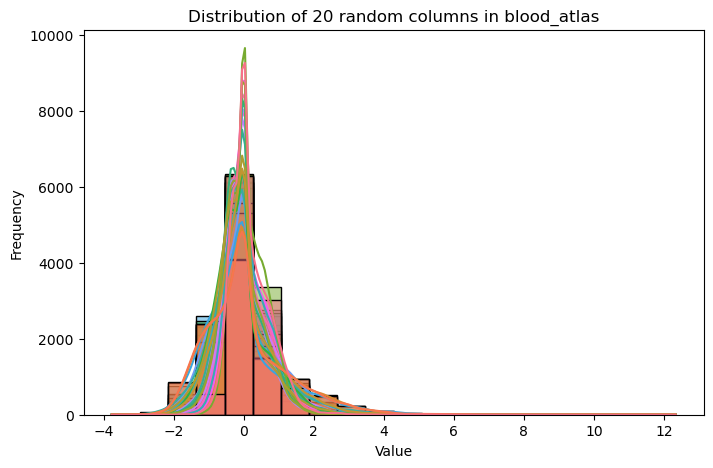

mann2017: (9639, 100) -> (9639, 100)


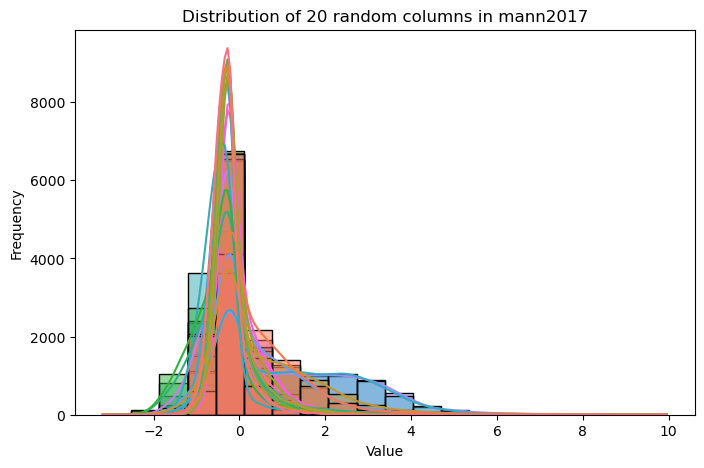

monaco: (20151, 18) -> (20151, 18)


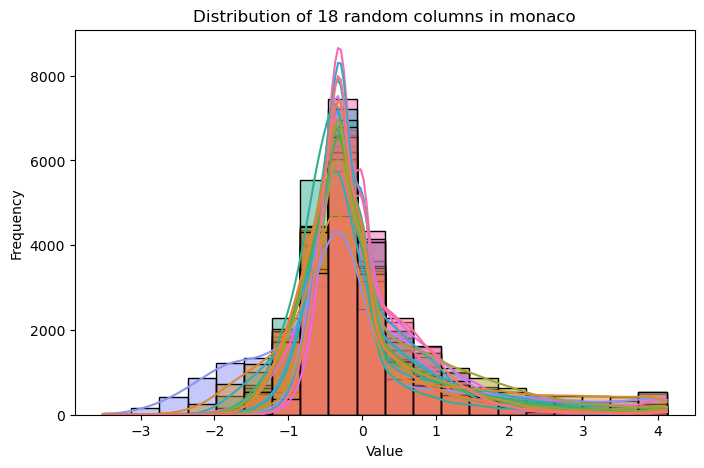

schmiedel: (19869, 10) -> (19869, 10)


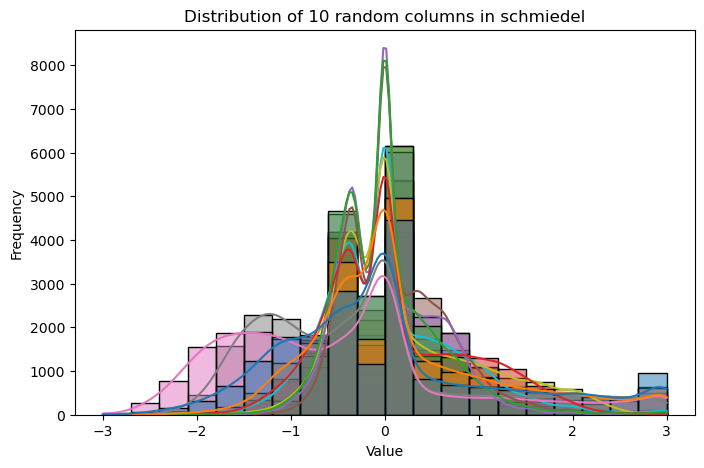

In [ ]:
# # normalize all dataframes in dict_of_dfs and plot their distributions
# dict_of_dfs_scaled = {}


# def plot_dist_safe(data, dist_name, n_genes=20):
#     n = min(n_genes, data.shape[1])
#     random_genes = np.random.choice(data.columns, size=n, replace=False)
#     plt.figure(figsize=(8, 5))
#     sns.histplot(data.loc[:, random_genes], bins=20, kde=True, legend=False)
#     plt.title(f"Distribution of {n} random columns in {dist_name}")
#     plt.xlabel("Value")
#     plt.ylabel("Frequency")
#     plt.show()


# for name, df in dict_of_dfs.items():
#     df.index = df.index.astype(str)
#     df_scaled = normalize(df)
#     dict_of_dfs_scaled[name] = df_scaled
#     print(f"{name}: {df.shape} -> {df_scaled.shape}")
#     plot_dist_safe(df_scaled, name)

# dict_of_dfs = dict_of_dfs_scaled

In [ ]:
# for name, df in dict_of_dfs.items():
#     df.to_csv(path_data_intermediate / f"251020_{name}_normalized.csv")

## 5. Making umaps

## 6. Creating AnnData objects

In [8]:
cell_lineages = {
    # Granulocytes
    "Basophil": "Granulocyte",
    "Eosinophil": "Granulocyte",
    "Neutrophil": "Granulocyte",
    # Mononuclear phagocytes
    "Monocyte_Classical": "Monocyte",
    "Monocyte_Intermediate": "Monocyte",
    "Monocyte_Nonclassical": "Monocyte",
    # Dendritic cells
    "Myeloid_DC": "Dendritic_Cell",
    "Plasmacytoid_DC": "Dendritic_Cell",
    # B cell types
    "B_Naive": "B_Cell",
    "B_Memory": "B_Cell",
    # NK cells
    "NK_Bright": "NK_Cell",
    "NK_Dim": "NK_Cell",
    # CD4+ T cell subsets
    "CD4_Naive": "T_CD4",
    "CD4_CentralMemory": "T_CD4",
    "CD4_EffectorMemory": "T_CD4",
    "CD4_TEMRA": "T_CD4",
    "CD4_Treg": "T_CD4",
    "CD4_MemoryTfh": "T_CD4",
    "CD4_MemoryTh1": "T_CD4",
    "CD4_MemoryTh2": "T_CD4",
    "CD4_MemoryTh17": "T_CD4",
    # CD8+ T cell subsets
    "CD8_Naive": "T_CD8",
    "CD8_CentralMemory": "T_CD8",
    "CD8_EffectorMemory": "T_CD8",
    "CD8_TEMRA": "T_CD8",
    # Other specialized T-cell subsets
    "T_GammaDelta": "T_GammaDelta",
    "T_MAIT": "T_MAIT",
}

In [19]:
dict_of_dfs = {
    "blood_atlas": pd.DataFrame(),
    "mann2017": pd.DataFrame(),
    "monaco": pd.DataFrame(),
    "schmiedel": pd.DataFrame(),
}

for name, df in dict_of_dfs.items():
    df = pd.read_csv(path_data_intermediate / f"251020_{name}_renamed.csv", index_col=0)
    dict_of_dfs[name] = df

adata_dict = {}

for name, df in dict_of_dfs.items():
    adata = ad.AnnData(df.T)
    adata.var_names_make_unique()
    adata_dict[name] = adata

adata_dict

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


{'blood_atlas': AnnData object with n_obs × n_vars = 153 × 10667,
 'mann2017': AnnData object with n_obs × n_vars = 100 × 9639,
 'monaco': AnnData object with n_obs × n_vars = 18 × 20151,
 'schmiedel': AnnData object with n_obs × n_vars = 10 × 19869}

In [20]:
for name, adata in adata_dict.items():
    metadata_df = pd.DataFrame(index=adata.obs_names.tolist(), columns=["cell_type"])
    metadata_df["cell_type"] = [name.rsplit("_", 1)[0] for name in metadata_df.index]
    metadata_df["lineage"] = metadata_df["cell_type"].map(cell_lineages)
    adata.obs = metadata_df
    # convert to categorical dtypes
    for col in ["cell_type", "lineage"]:
        if col in adata.obs.columns:
            adata.obs[col] = pd.Categorical(adata.obs[col])

In [10]:
sc.set_figure_params(dpi=300, color_map="viridis_r")
sc.settings.verbosity = 0

In [ ]:
for name, adata in adata_dict.items():
    print(f"Processing dataset: {name}")
    sc.pp.filter_genes(adata, min_cells=3)
    out_path = path_data_intermediate / f"251020_{name}.h5ad"
    sc.write(out_path, adata)
    print(f"Saved {name} -> {out_path}")

    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)
    # sc.pp.neighbors(adata, n_pcs=10, n_neighbors=5)
    # sc.tl.umap(adata)

    # sc.pl.umap(
    #     adata,
    #     color=["cell_type"],
    #     legend_loc="right margin",
    #     legend_fontsize=8,
    #     size=100,
    #     sort_order=False,
    #     title=f"{name} UMAP",
    # )

Processing dataset: blood_atlas
Saved blood_atlas -> /home/t.afanasyeva/multimodal_blood_atlas/data/intermediate/251020_blood_atlas.h5ad
Processing dataset: mann2017
Saved mann2017 -> /home/t.afanasyeva/multimodal_blood_atlas/data/intermediate/251020_mann2017.h5ad
Processing dataset: monaco
Saved monaco -> /home/t.afanasyeva/multimodal_blood_atlas/data/intermediate/251020_monaco.h5ad
Processing dataset: schmiedel
Saved schmiedel -> /home/t.afanasyeva/multimodal_blood_atlas/data/intermediate/251020_schmiedel.h5ad


In [21]:
palette = [
    "#003AA3",
    "#7D87B9",
    "#BDC0D3",
    "#D5BBBF",
    "#BD7A87",
    "#8E063B",
    "#4A6FE3",
    "#8595E1",
    "#B5BBE3",
    "#E6AFB9",
    "#E07B91",
    "#E07B91",
    "#D23A66",
    "#11C638",
    "#8DD593",
    "#C6DEC7",
    "#EAD3C6",
    "#EFB688",
    "#EF9505",
    "#0FCFC0",
    "#9CDED6",
    "#D5EAE7",
    "#F3E1EB",
    "#F6C4E1",
    "#F798D2",
    "#797979",
    "#C7C7C7",
]
# desired legend order (set your preferred order here)
legend_order = list(
    cell_lineages.keys()
)  # example default order; replace with your list of strings

# ensure cell_type is categorical
if not pd.api.types.is_categorical_dtype(adata.obs["cell_type"]):
    adata.obs["cell_type"] = pd.Categorical(adata.obs["cell_type"])

/tmp/ipykernel_2606820/3102901128.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs["cell_type"]):


Processing dataset: blood_atlas


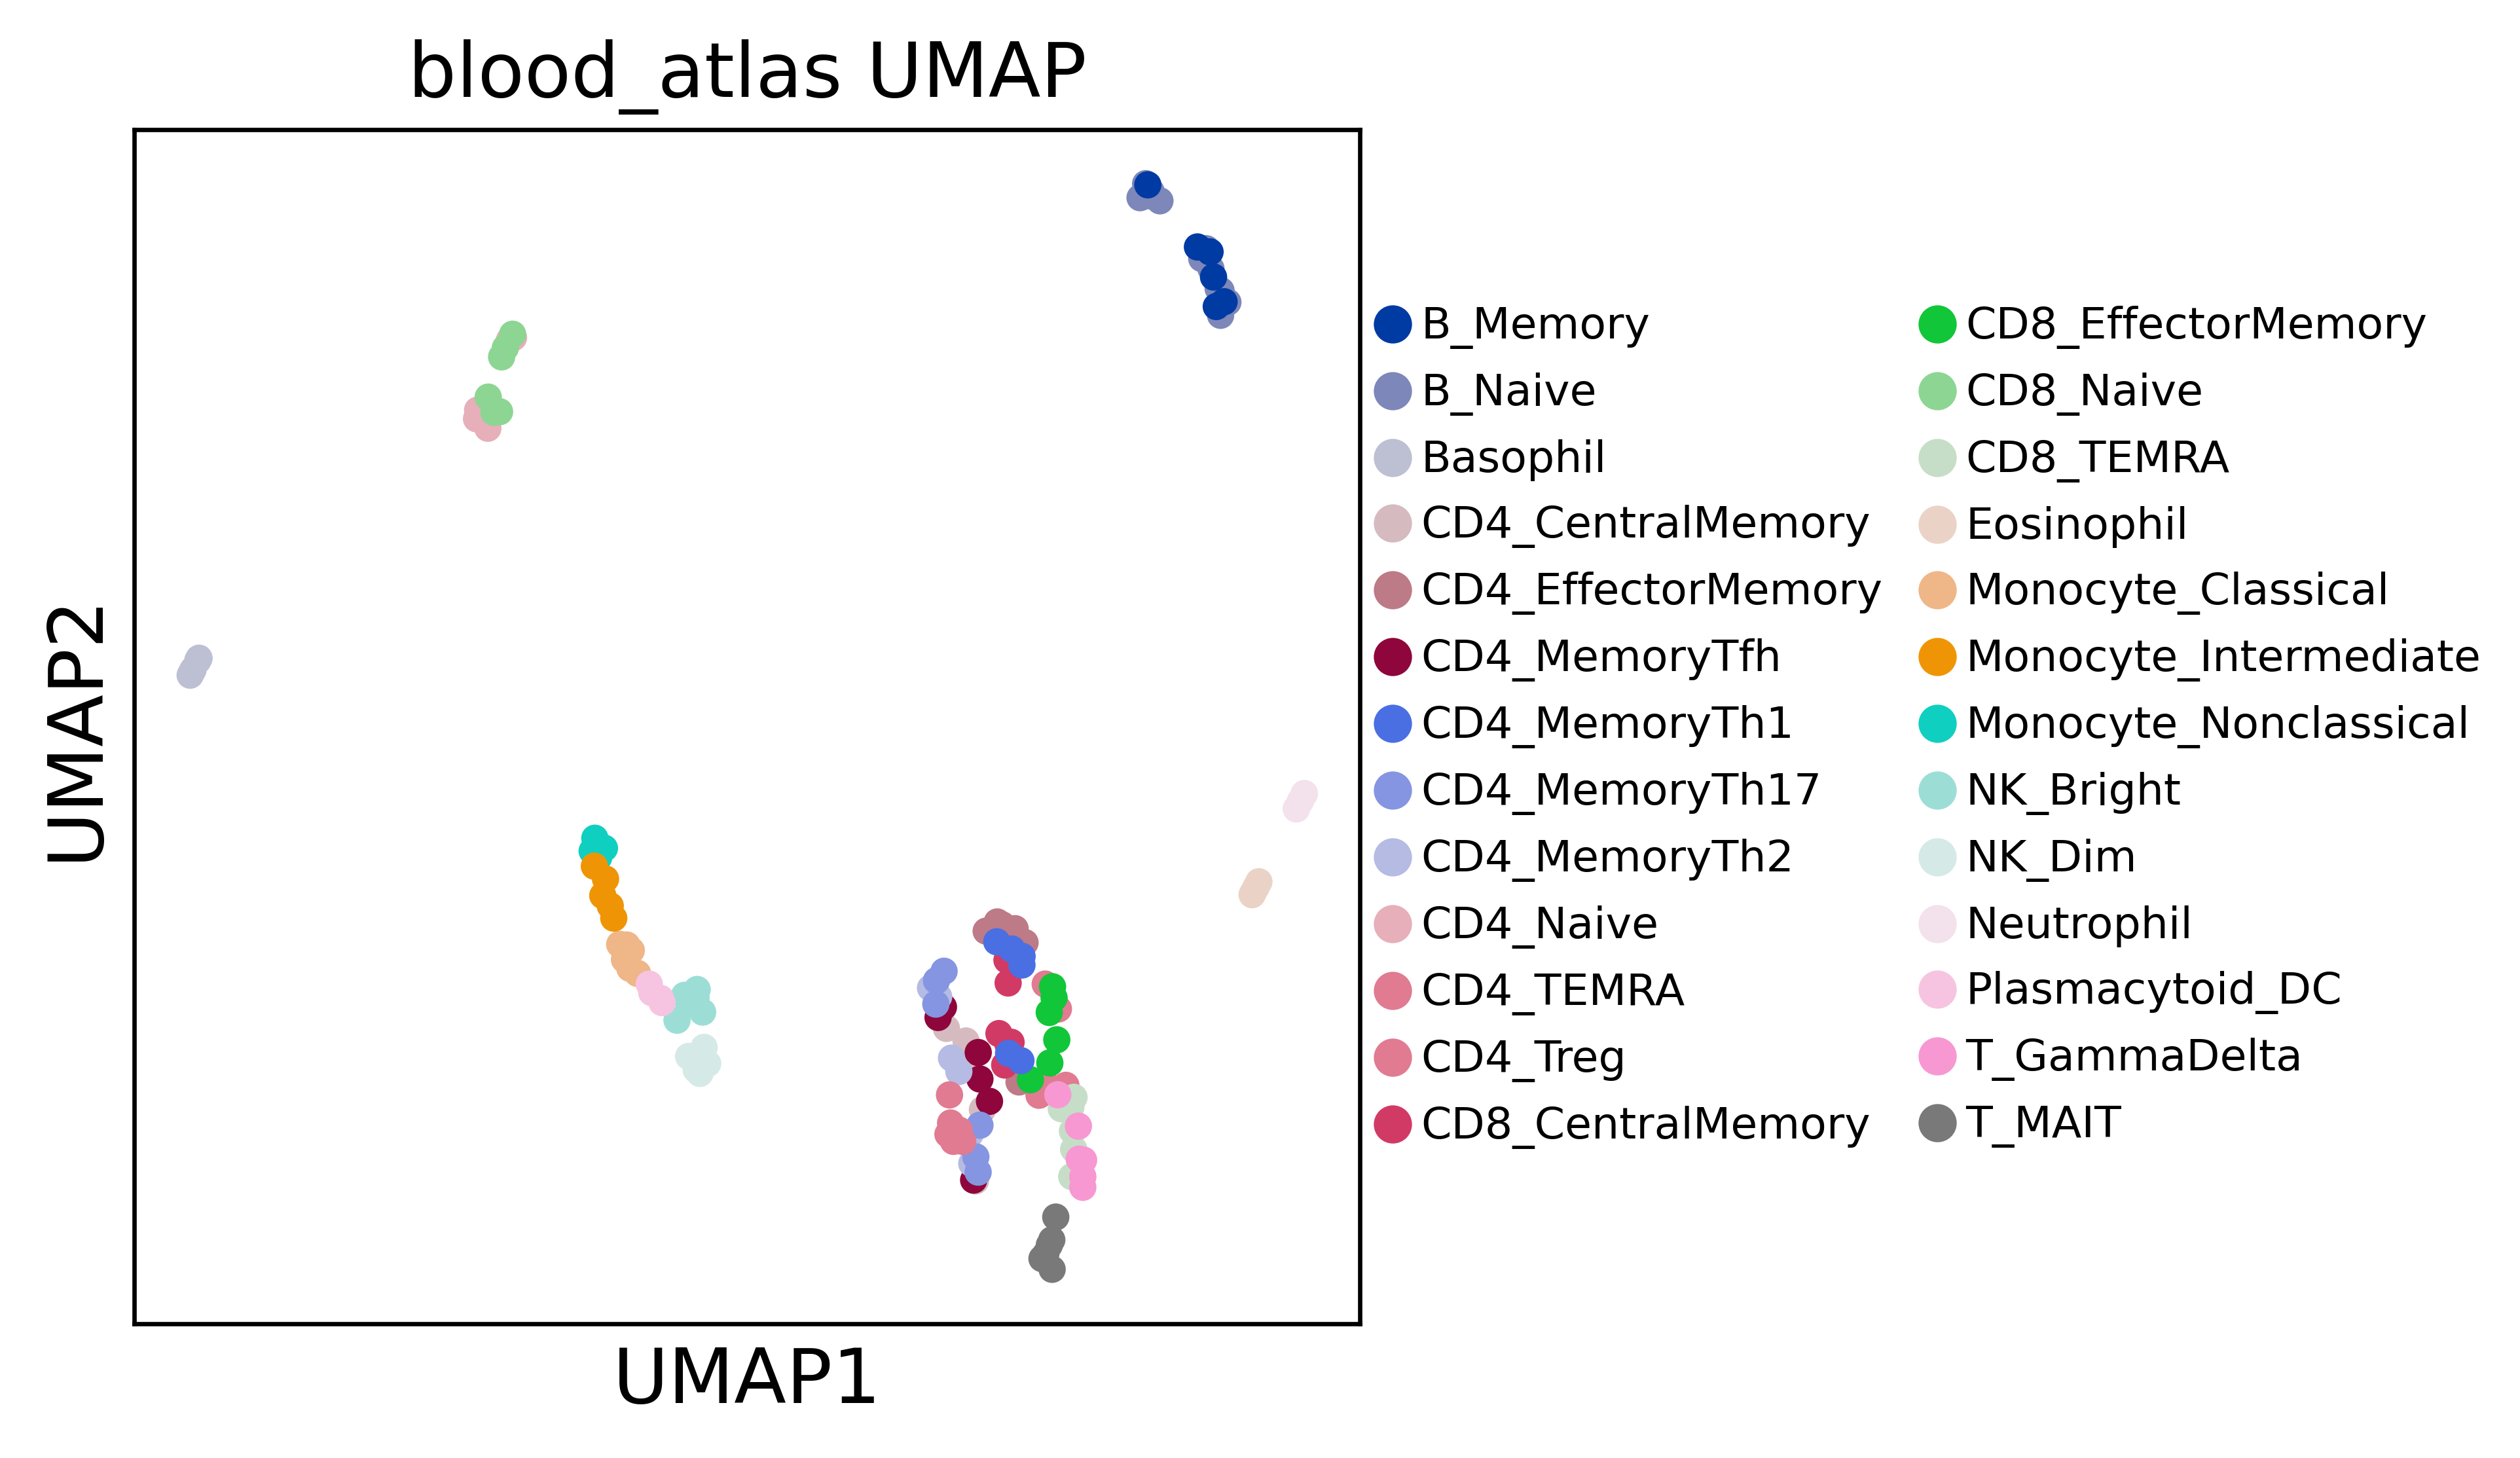

Processing dataset: mann2017


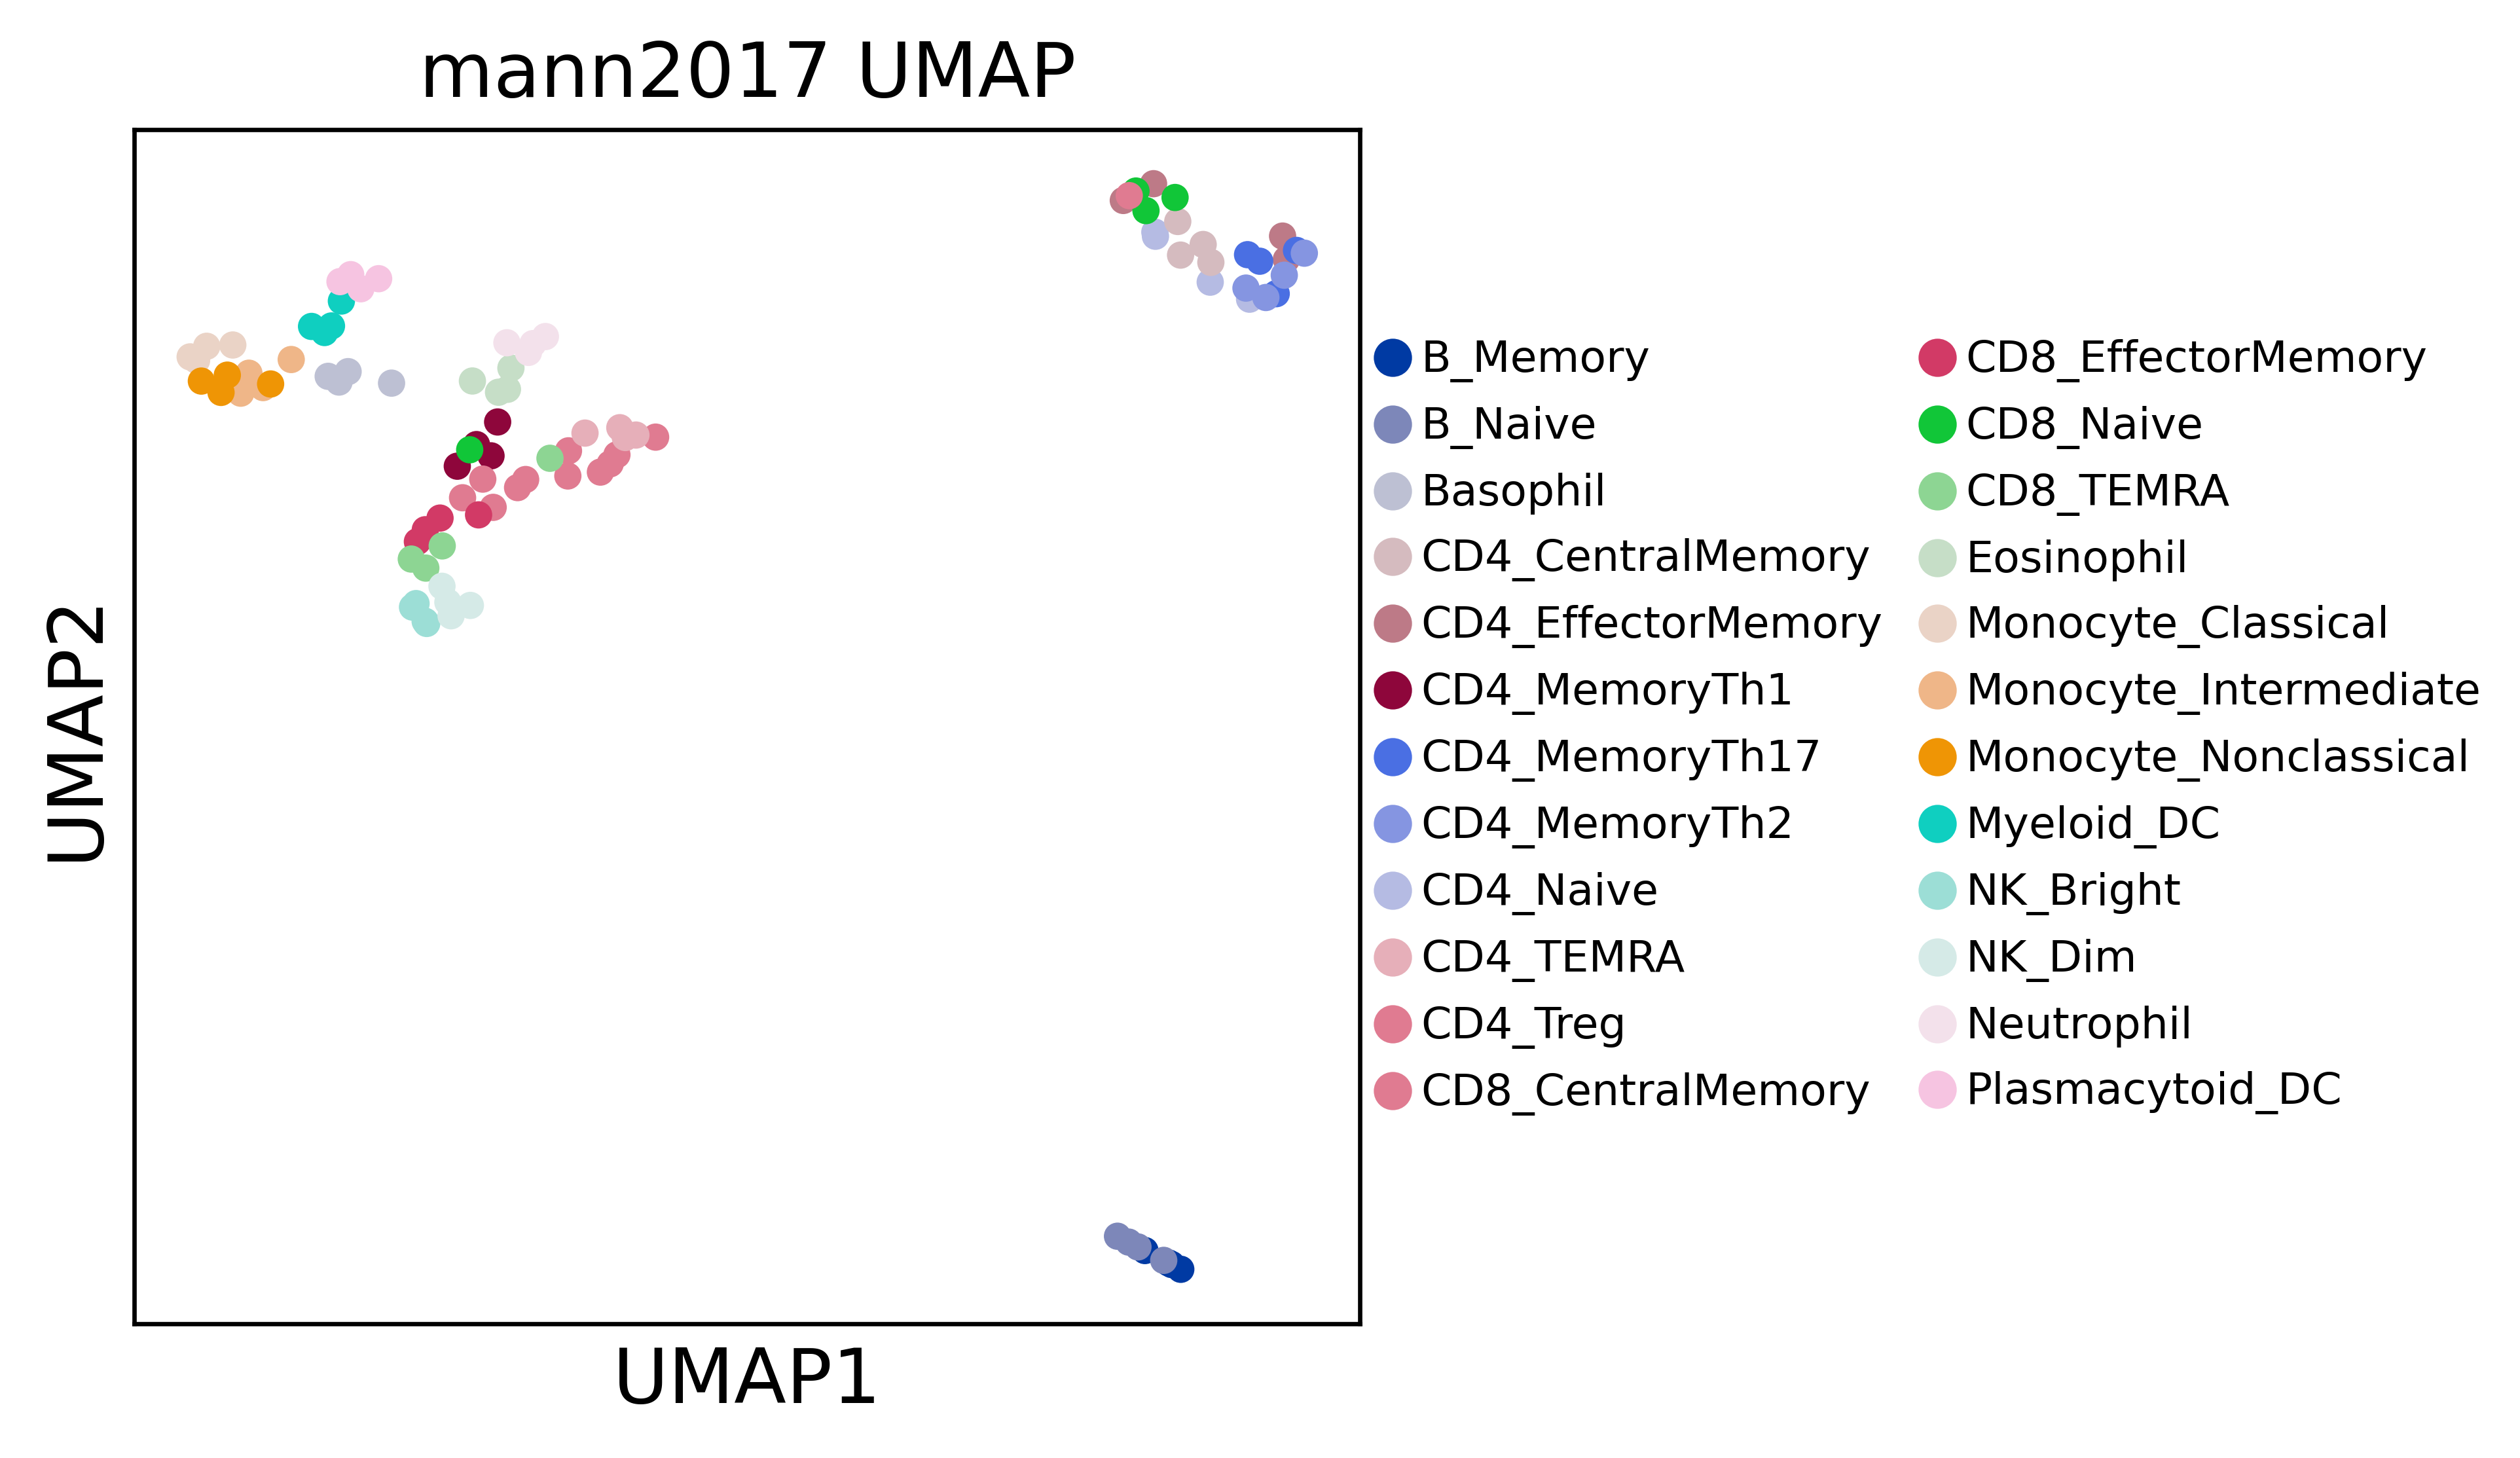

Processing dataset: monaco


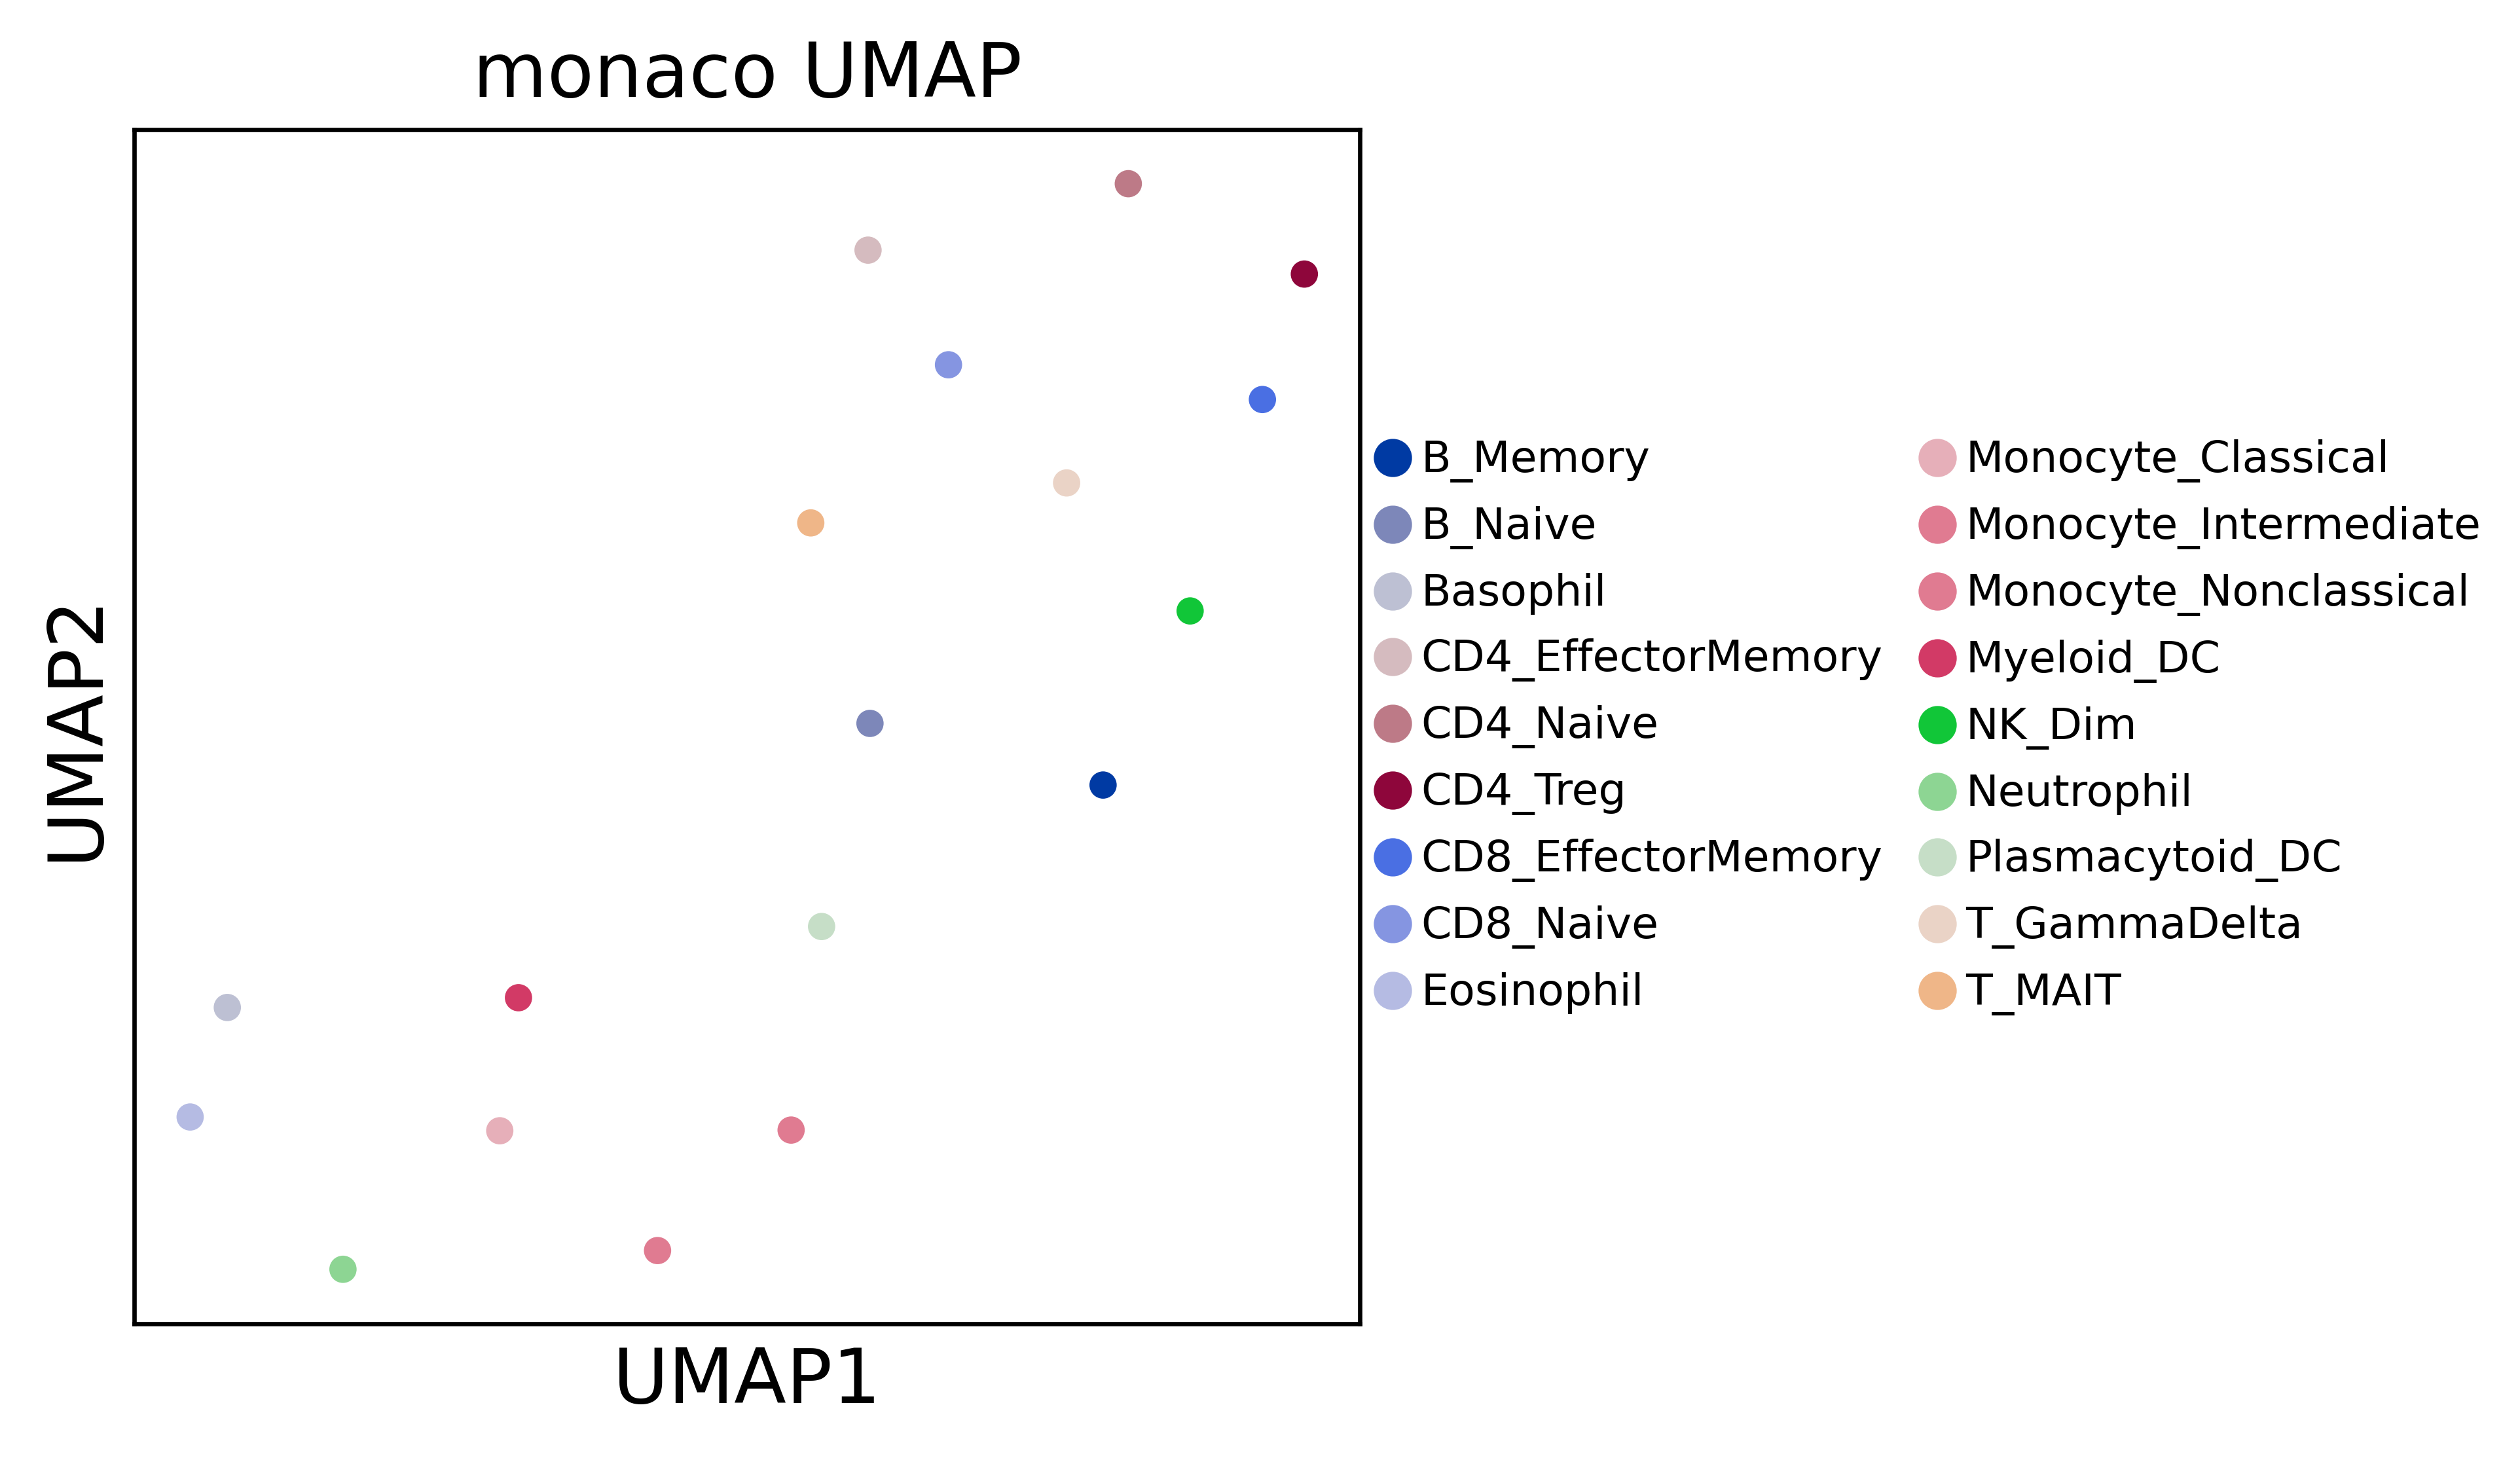

Processing dataset: schmiedel


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
for name, adata in adata_dict.items():
    print(f"Processing dataset: {name}")
    # sc.pp.filter_genes(adata, min_cells=3)
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)
    # sc.pp.neighbors(adata, n_pcs=10, n_neighbors=5)
    # sc.tl.umap(adata)
    sc.pl.umap(
        adata,
        color=["cell_type"],
        palette=palette,
        legend_loc="right margin",
        legend_fontsize=8,
        size=100,
        sort_order=False,
        title=f"{name} UMAP",
    )

In [ ]:
path_out = p / "data" / "out"

In [23]:
path_out / f"_{name}_umap_cell_type.png"

PosixPath('/home/t.afanasyeva/multimodal_blood_atlas/data/out/_schmiedel_umap_cell_type.png')

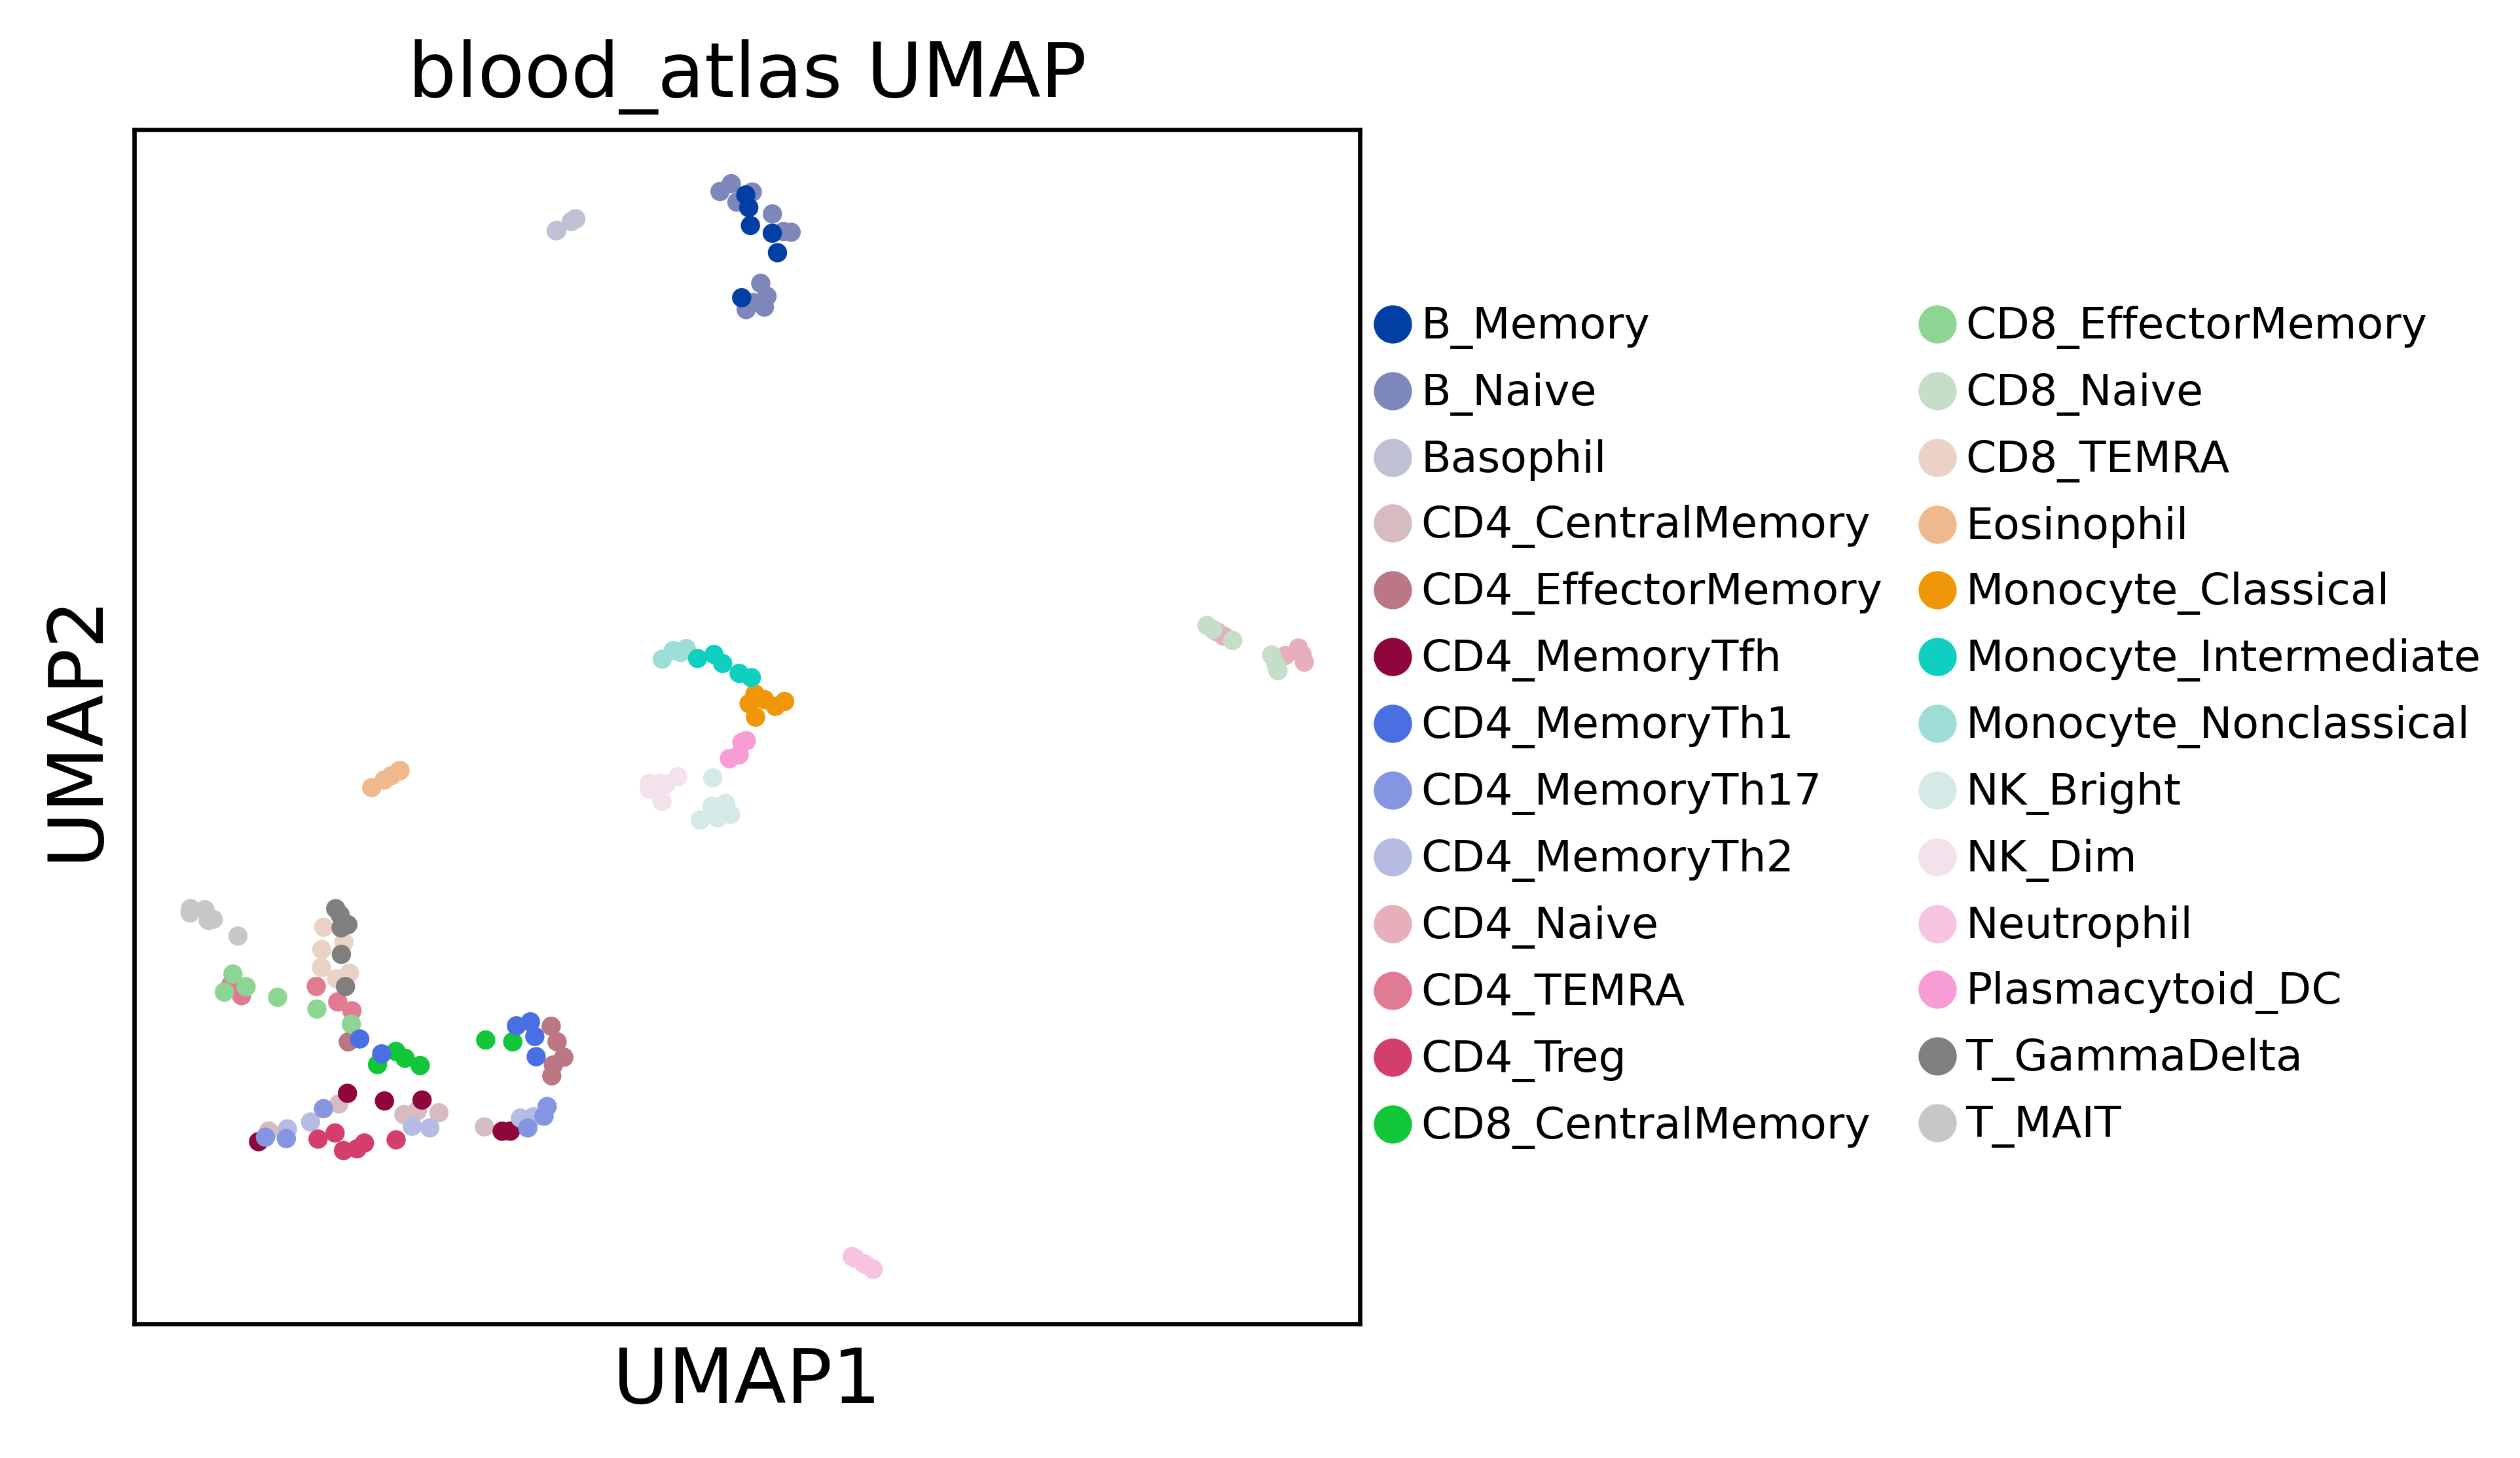

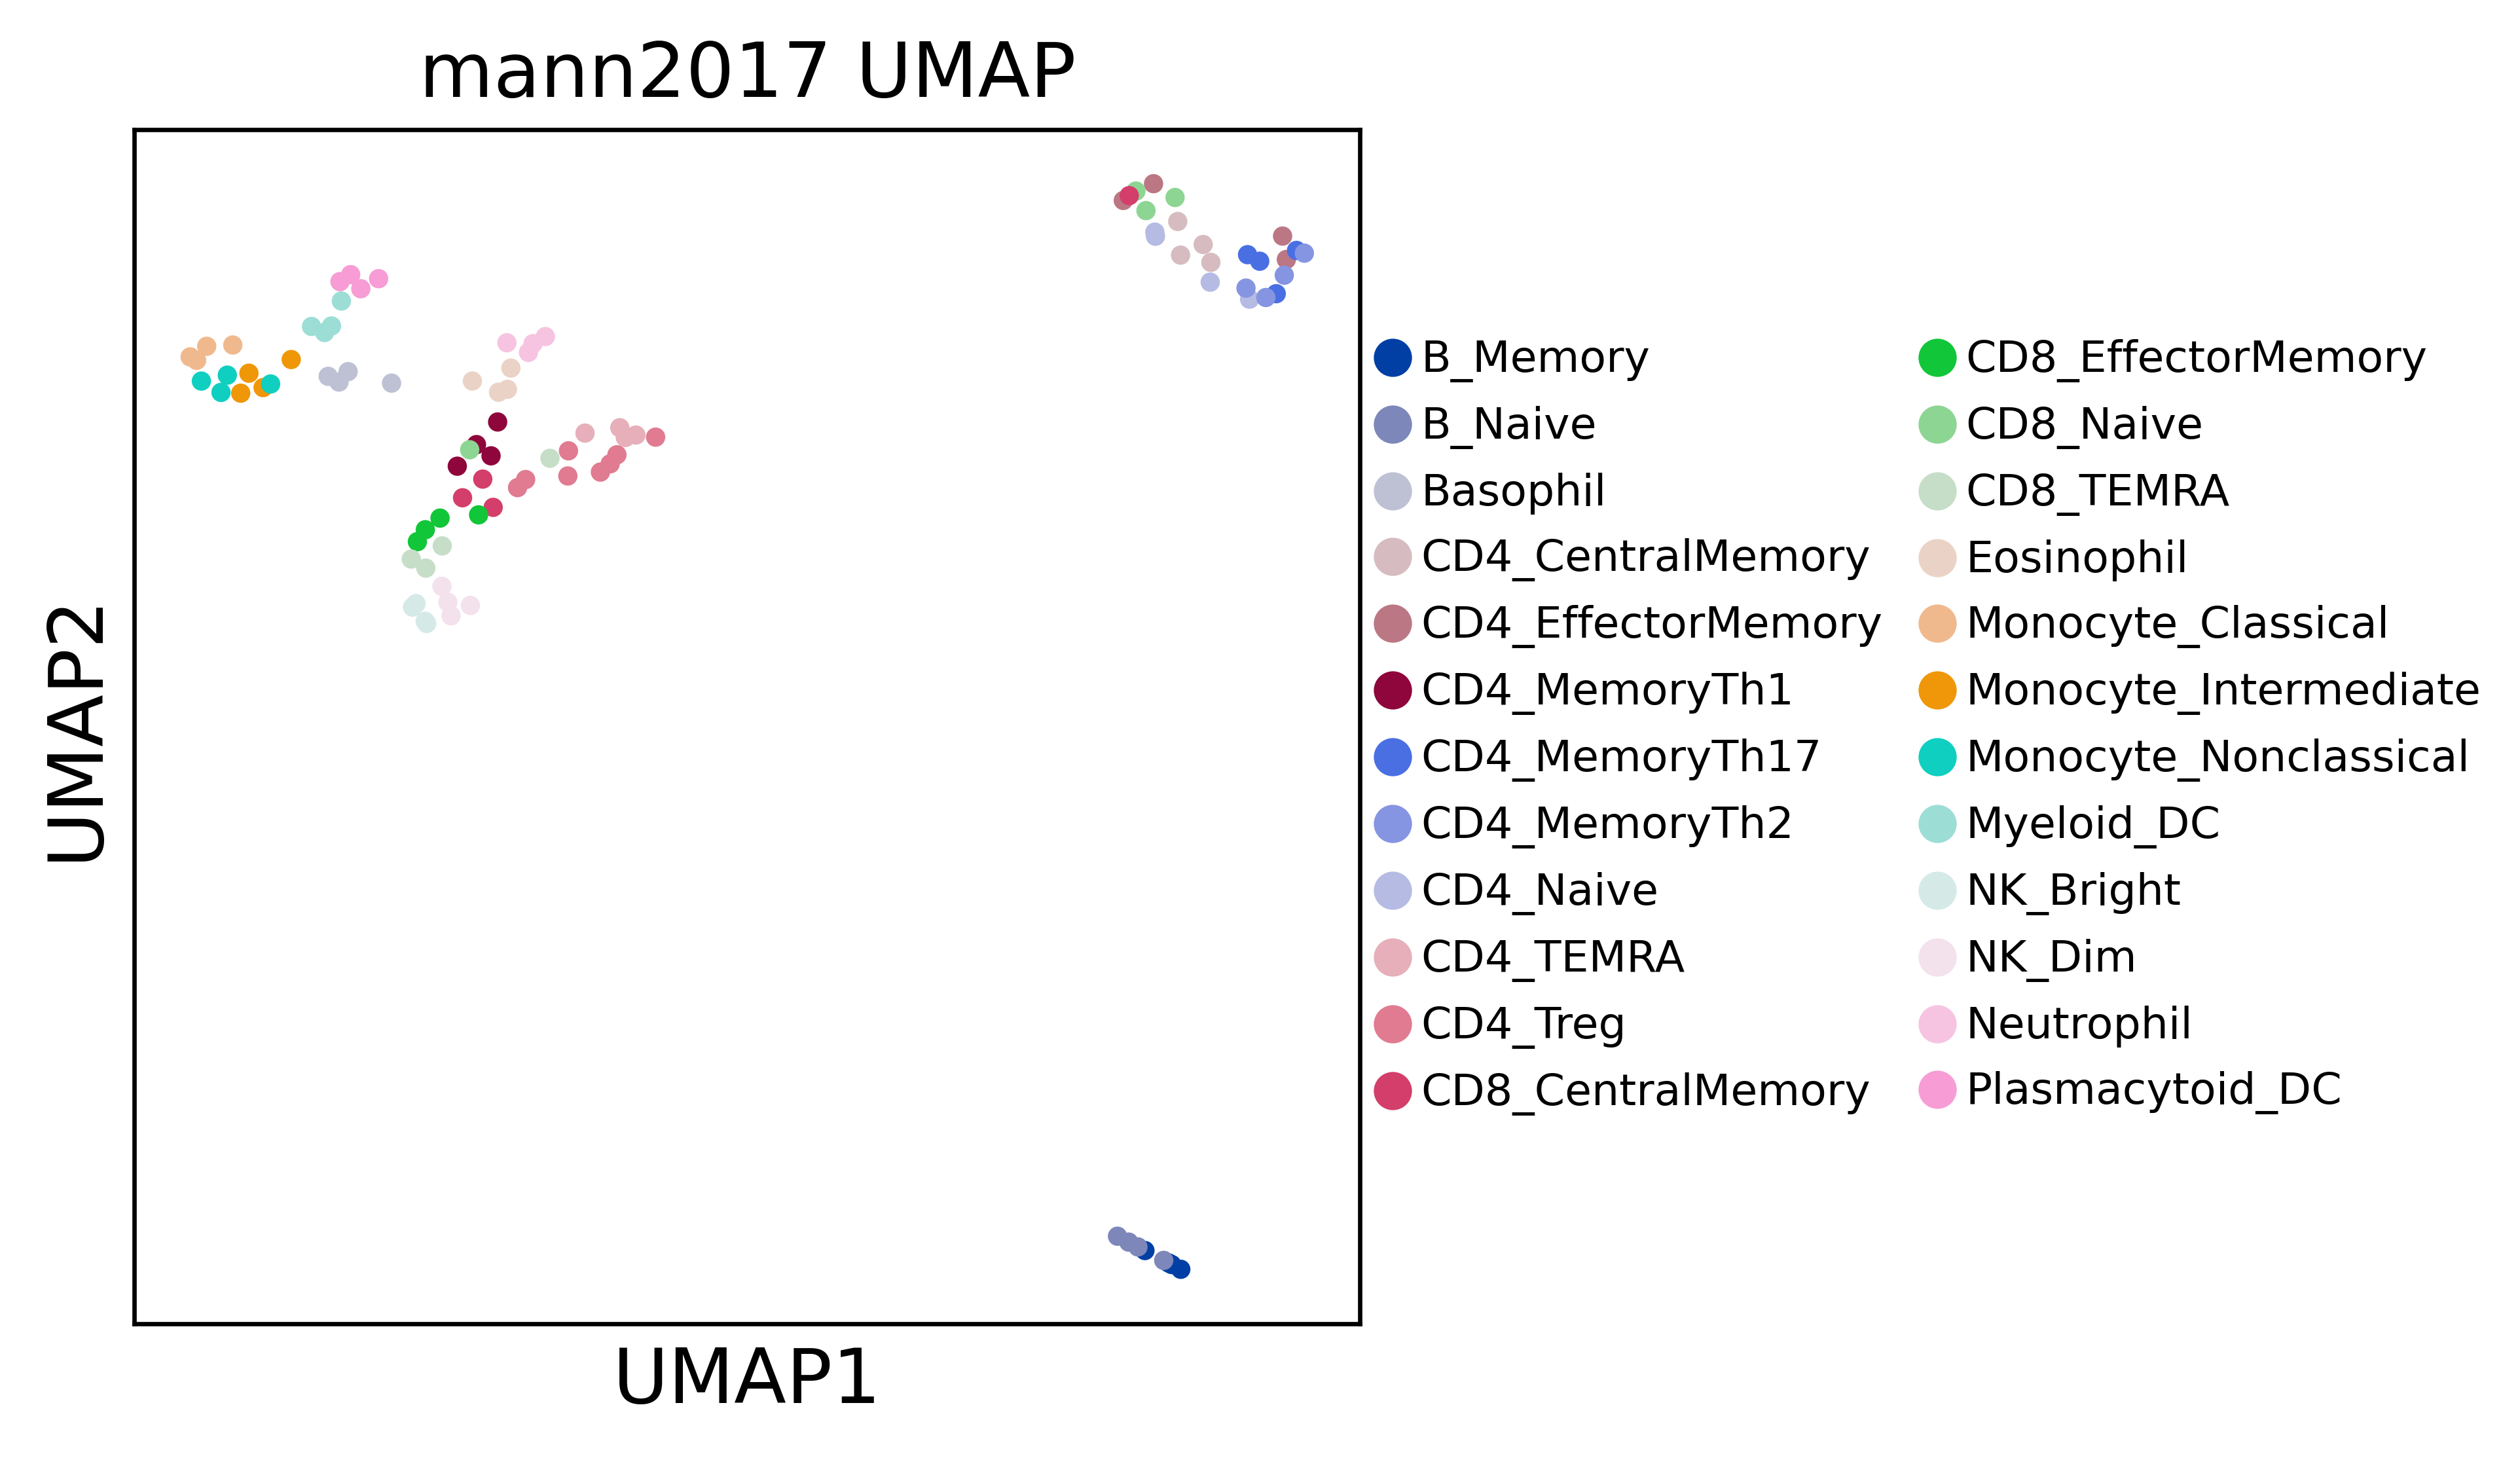

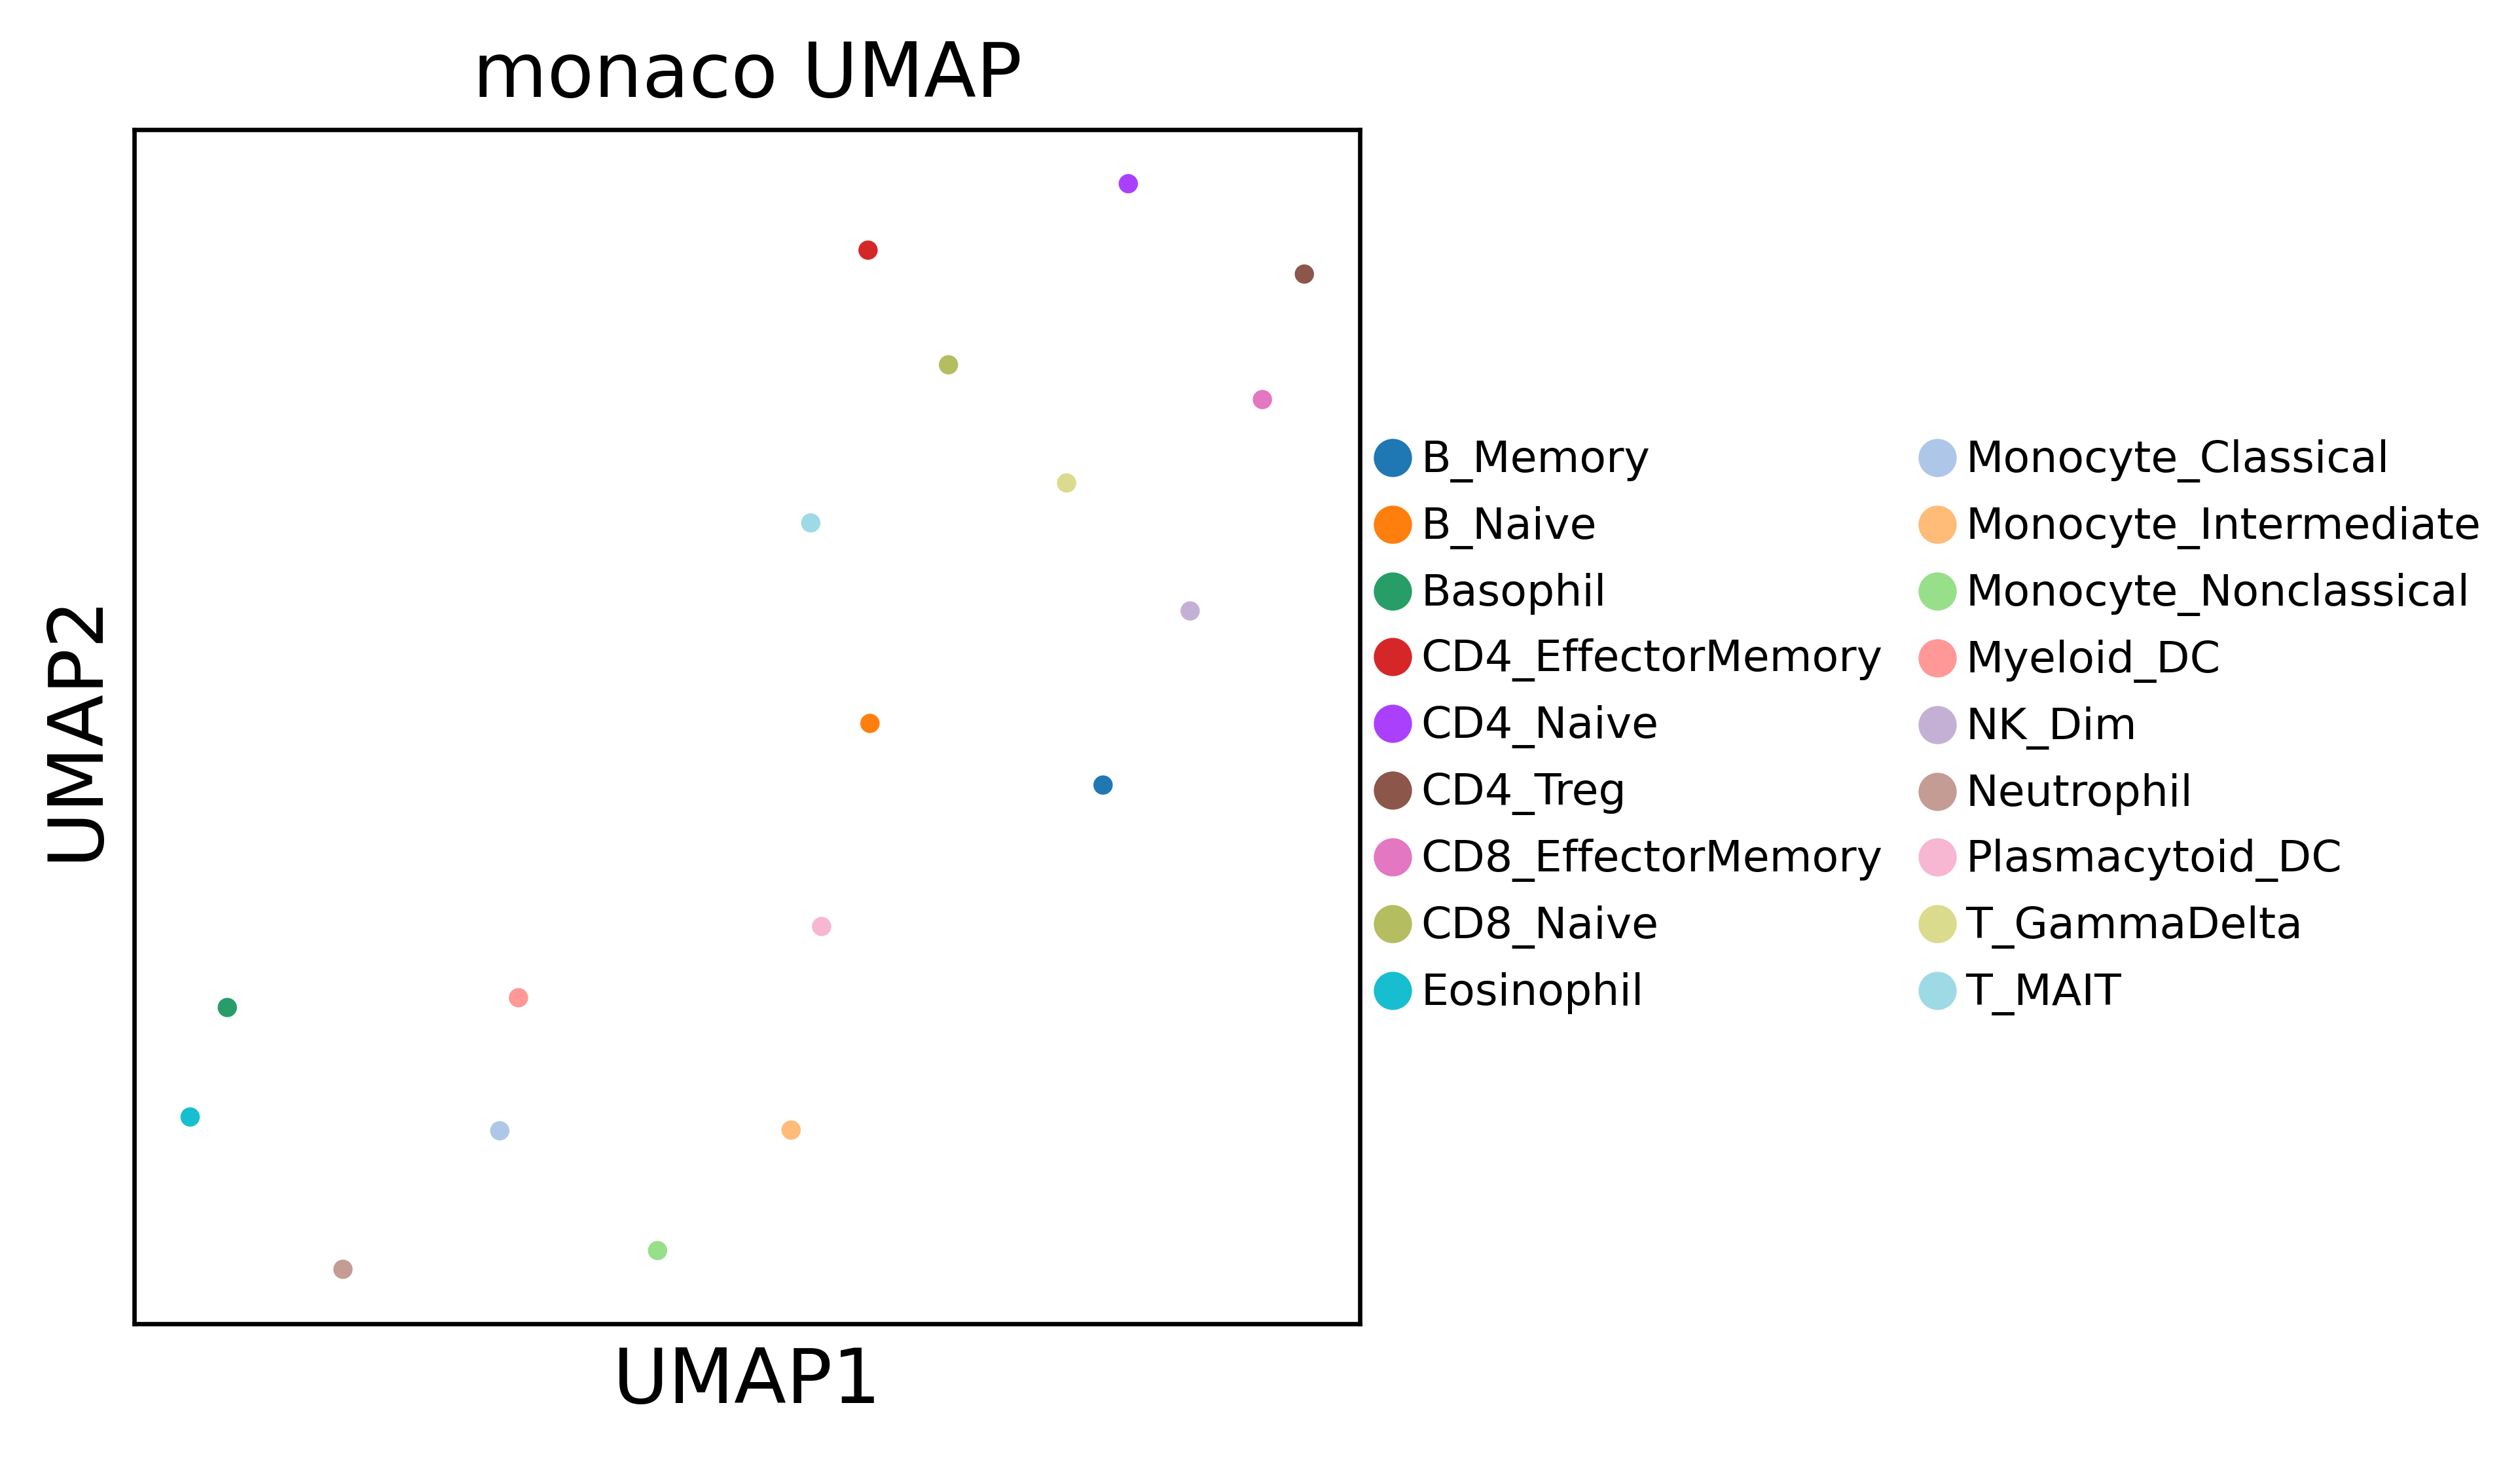

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
for name, adata in adata_dict.items():

    sc.pl.umap(
        adata,
        color=["cell_type"],
        legend_loc="right margin",
        legend_fontsize=8,
        size=50,
        sort_order=False,
        title=f"{name} UMAP",
        save=path_out / f"{name}_umap_cell_type.png",
    )

In [18]:
mdata = md.MuData(adata_dict)

metadata_df = pd.DataFrame(index=mdata.obs_names.tolist(), columns=["cell_type"])
metadata_df["cell_type"] = [name.rsplit("_", 1)[0] for name in metadata_df.index]
metadata_df["lineage"] = metadata_df["cell_type"].map(cell_lineages)
mdata.obs = metadata_df

/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:963: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push

In [19]:
mdata.write(path_data_intermediate / "251020_mudata.h5mu")

... storing 'cell_type' as categorical
... storing 'lineage' as categorical


/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/t.afanasyeva/miniforge3/envs/MOFA/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
